In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu 06 07 13:06:58 2019

@author: shuxin.jin@hotmail.com
"""

'\nCreated on Thu 06 07 13:06:58 2019\n\n@author: shuxin.jin@hotmail.com\n'

### Import neccessary packages ###

In [2]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import seaborn as sbn
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [3]:
# define the features
STATISTICS=        [  'Market Cap',        #https://baike.baidu.com/item/%E8%82%A1%E7%A5%A8%E5%B8%82%E5%80%BC
                    'EBITDA',        #https://www.mg21.com/guide/?p=683      
                    'Price/Book',     #https://wiki.mbalib.com/wiki/%E5%B8%82%E5%87%80%E7%8E%87
                    'D/E Ratio',      #https://investinganswers.com/dictionary/d/debt-equity-ratio
                    'Return on Equity', #https://wiki.mbalib.com/wiki/Return_on_Equity
                    'Profit Margin',     #https://wiki.mbalib.com/wiki/%E9%94%80%E5%94%AE%E5%87%80%E5%88%A9%E7%8E%87
                    'Forward P/E',       #https://www.zhihu.com/question/22479319
                    'Enterprise Value',  #https://zhuanlan.zhihu.com/p/25634226
                    'Total Cash Per Share', #https://www.investopedia.com/terms/c/cash-per-share.asp  ,  https://www.zybang.com/question/e7aeb6dc3617ef1563e7860cce217625.html
                    'Current Ratio'  #https://www.investopedia.com/terms/c/currentratio.asp   
                 ] 

# define the remove features
#EnterpriseValue_EBITDA repeated.
cols_to_remove = ['Ticker','Date','SP500','Unix', 'sp500_p_change', 'stock_p_change','Short%ofFloat','Difference','EnterpriseValue_EBITDA']


In [4]:
#global variables
fname= "key_stats.csv"
sample_win ="sample_win.csv"

### Read the file ###

In [5]:
# load the file
financeData = pd.read_csv(fname, keep_default_na=False)
winData= pd.read_csv(sample_win, keep_default_na=False)

In [6]:
# Check the initial shape of the data. The result is 2930 rows, 82 columns
print ('Initial shape of the financeData is', financeData.shape)


Initial shape of the financeData is (212, 44)


In [7]:
# See the initial data types of each columns
financeData.dtypes

Order                          int64
Beta                         float64
Book Value Per Share         float64
Cash Flow                      int64
Current Ratio                float64
D/E Ratio                    float64
Date                          object
Difference                   float64
Diluted EPS                  float64
EBITDA                       float64
Earnings Growth              float64
Enterprise Value             float64
Enterprise Value/EBITDA      float64
Enterprise Value/Revenue     float64
Forward P/E                  float64
Gross Profit                   int64
Held by Insiders             float64
Held by Institutions         float64
Market Cap                   float64
Net Income Avl to Common       int64
Operating Margin             float64
PEG Ratio                    float64
Price                        float64
Price/Book                   float64
Price/Sales                  float64
Profit Margin                float64
Return on Assets             float64
R

In [8]:
# Check duplicates row in dataframe. The result is we find no duplicates in the data row.
financeData[financeData.duplicated(keep=False)]

,Order,Beta,Book Value Per Share,Cash Flow,Current Ratio,D/E Ratio,Date,Difference,Diluted EPS,EBITDA,...,Short Ratio,Status,Ticker,Total Cash,Total Cash Per Share,Total Debt,Trailing P/E,Unix,sp500_p_change,stock_p_change


In [9]:
# Removing spaces from column names to have better access
financeData.columns = financeData.columns.str.replace(' ',"")
financeData.columns = financeData.columns.str.replace('/',"_")
# Change the empty field into NAN
financeData.replace(to_replace = "", value = np.NAN,inplace=True)

#sample data of win , will use finally
winData.columns = winData.columns.str.replace(' ',"")
winData.columns = winData.columns.str.replace('/',"_")
# Change the empty field into NAN
winData.replace(to_replace = "", value = np.NAN,inplace=True)


# See all the columns in dataframe financeData
financeData.columns

Index(['Order', 'Beta', 'BookValuePerShare', 'CashFlow', 'CurrentRatio',
       'D_ERatio', 'Date', 'Difference', 'DilutedEPS', 'EBITDA',
       'EarningsGrowth', 'EnterpriseValue', 'EnterpriseValue_EBITDA',
       'EnterpriseValue_Revenue', 'ForwardP_E', 'GrossProfit',
       'HeldbyInsiders', 'HeldbyInstitutions', 'MarketCap',
       'NetIncomeAvltoCommon', 'OperatingMargin', 'PEGRatio', 'Price',
       'Price_Book', 'Price_Sales', 'ProfitMargin', 'ReturnonAssets',
       'ReturnonEquity', 'Revenue', 'RevenueGrowth', 'RevenuePerShare',
       'SP500', 'SharesShort(asof', 'Short%ofFloat', 'ShortRatio', 'Status',
       'Ticker', 'TotalCash', 'TotalCashPerShare', 'TotalDebt', 'TrailingP_E',
       'Unix', 'sp500_p_change', 'stock_p_change'],
      dtype='object')

In [10]:
# Check how many columns contains empty value (empty row)
financeData.columns[financeData.isnull().sum() != 0].size

0

In [11]:
# Display which columns has empty value (empty row)
financeData.columns[financeData.isnull().sum() != 0]

Index([], dtype='object')

In [12]:
# See how many values are empty in each column which has empty value (empty row)
financeData.loc[:,financeData.columns[financeData.isnull().sum() != 0]].isnull().sum().sort_values()

Series([], dtype: float64)

## DATA CLEANING ##

**Part 1. Fill in missing value ,but this base dataset is integrity**

In [13]:
# Check again the missing value
financeData.columns[financeData.isnull().sum() != 0]

Index([], dtype='object')

c. Convert Y target to boolean value

In [14]:
# Convert Status
financeData["Status"].replace({"underperform": 0, "outperform": 1}, inplace=True)
financeData["Status"].sample(10)

#win Sample data,finally test it
winData["Status"].replace({"underperform": 0, "outperform": 1}, inplace=True)


64    NaN
145   NaN
125   NaN
198   NaN
40    NaN
81    NaN
142   NaN
133   NaN
119   NaN
27    NaN
Name: Status, dtype: float64

d. For the other categorical variables which is not ordinal values, we can drop it

In [15]:
# See all the columns in dataframe financeData
financeData.columns


Index(['Order', 'Beta', 'BookValuePerShare', 'CashFlow', 'CurrentRatio',
       'D_ERatio', 'Date', 'Difference', 'DilutedEPS', 'EBITDA',
       'EarningsGrowth', 'EnterpriseValue', 'EnterpriseValue_EBITDA',
       'EnterpriseValue_Revenue', 'ForwardP_E', 'GrossProfit',
       'HeldbyInsiders', 'HeldbyInstitutions', 'MarketCap',
       'NetIncomeAvltoCommon', 'OperatingMargin', 'PEGRatio', 'Price',
       'Price_Book', 'Price_Sales', 'ProfitMargin', 'ReturnonAssets',
       'ReturnonEquity', 'Revenue', 'RevenueGrowth', 'RevenuePerShare',
       'SP500', 'SharesShort(asof', 'Short%ofFloat', 'ShortRatio', 'Status',
       'Ticker', 'TotalCash', 'TotalCashPerShare', 'TotalDebt', 'TrailingP_E',
       'Unix', 'sp500_p_change', 'stock_p_change'],
      dtype='object')

drop columns

In [16]:

# can remove the key columns as below sentence .
financeData.drop(cols_to_remove, inplace=True, axis=1)

#sample data , verify finally.
winData.drop(cols_to_remove, inplace=True, axis=1)

In [17]:

# check
financeData.loc[:, ].sample(10)
#financeData.loc[:, STATISTICS].sample(10)

,Order,Beta,BookValuePerShare,CashFlow,CurrentRatio,D_ERatio,DilutedEPS,EBITDA,EarningsGrowth,EnterpriseValue,...,Revenue,RevenueGrowth,RevenuePerShare,SharesShort(asof,ShortRatio,Status,TotalCash,TotalCashPerShare,TotalDebt,TrailingP_E
48,48,0.790,5.750,29280000000,1.510,0.110,3.150,7.64,28.0,2.928000e+10,...,1.13,20.6,40.450,1235000,1.800,1,5260000000,8.16,4.620000e+05,17.02
159,159,0.770,16.132,42070000,1.078,0.781,1.450,9.63,9.5,8.190000e+09,...,0.42,0.2,71.283,1311000,14.332,0,10720000,0.40,3.330000e+09,12.89
92,92,1.060,5.614,25796000,1.614,1.614,1.246,26.86,277.1,4.130000e+09,...,3.97,15.4,8.332,458000,2.112,1,35393000,3.12,1.614000e+00,32.07
9,9,2.280,14.660,20950000000,1.360,48.260,0.870,6.18,136.8,2.095000e+10,...,0.89,27.0,22.580,5373000,1.900,0,1270000000,1.19,9.350000e+09,13.78
140,140,1.270,6.490,10140000000,3.130,22.770,1.450,3.36,287.0,1.014000e+10,...,0.90,10.7,8.480,2348000,1.200,0,5760000000,4.37,1.950000e+09,7.30
139,139,2.292,5.501,1390000000,4.494,0.049,0.787,13.44,155.4,2.370000e+10,...,2.96,11.6,4.652,3764000,1.054,0,6580000000,3.87,4.563000e+07,21.94
82,82,0.760,28.760,3470000000,1.730,46.710,1.890,11.15,32.6,2.847000e+10,...,0.31,2.7,138.080,882000,2.000,1,1630000000,2.48,8.860000e+09,17.53
173,173,1.865,8.740,36459000,1.958,1.958,2.126,9.55,5.2,3.890000e+09,...,2.05,7.0,19.529,376000,2.112,1,44341000,5.09,1.958000e+00,23.41
38,38,0.230,15.560,8970000000,1.540,62.850,3.010,9.24,12.3,1.030000e+11,...,2.66,4.1,24.940,2161000,3.100,1,8100000000,5.15,1.541000e+10,20.26
58,58,1.610,12.120,1530000000,3.140,25.260,1.560,10.62,21.1,1.545000e+10,...,3.65,1.7,8.550,1318000,3.400,0,2770000000,5.60,1.510000e+09,21.69


In [18]:
# Check columns are not int
financeData.select_dtypes(exclude=[np.integer]).columns

Index(['Beta', 'BookValuePerShare', 'CurrentRatio', 'D_ERatio', 'DilutedEPS',
       'EBITDA', 'EarningsGrowth', 'EnterpriseValue',
       'EnterpriseValue_Revenue', 'ForwardP_E', 'HeldbyInsiders',
       'HeldbyInstitutions', 'MarketCap', 'OperatingMargin', 'PEGRatio',
       'Price', 'Price_Book', 'Price_Sales', 'ProfitMargin', 'ReturnonAssets',
       'ReturnonEquity', 'Revenue', 'RevenueGrowth', 'RevenuePerShare',
       'ShortRatio', 'TotalCashPerShare', 'TotalDebt', 'TrailingP_E'],
      dtype='object')

In [19]:
# We need to convert those variables to numeric
cols = ['Beta', 'BookValuePerShare', 'CurrentRatio', 'D_ERatio', 'DilutedEPS',
       'EBITDA', 'EarningsGrowth', 'EnterpriseValue',
       'EnterpriseValue_Revenue', 'ForwardP_E', 'HeldbyInsiders',
       'HeldbyInstitutions', 'MarketCap', 'OperatingMargin', 'PEGRatio',
       'Price', 'Price_Book', 'Price_Sales', 'ProfitMargin', 'ReturnonAssets',
       'ReturnonEquity', 'Revenue', 'RevenueGrowth', 'RevenuePerShare',
       'ShortRatio', 'TotalCashPerShare', 'TotalDebt', 'TrailingP_E']

for col in cols:
    financeData[col] = pd.to_numeric(financeData[col])
    #sample data
    winData[col] = pd.to_numeric(winData[col])

# Check
financeData.loc[:, cols].head(10)

,Beta,BookValuePerShare,CurrentRatio,D_ERatio,DilutedEPS,EBITDA,EarningsGrowth,EnterpriseValue,EnterpriseValue_Revenue,ForwardP_E,...,ProfitMargin,ReturnonAssets,ReturnonEquity,Revenue,RevenueGrowth,RevenuePerShare,ShortRatio,TotalCashPerShare,TotalDebt,TrailingP_E
0,1.550,11.360,3.200,54.360,2.520,11.89,85.2,1.385000e+10,2.25,12.44,...,14.46,6.94,27.00,2.25,31.9,17.770,1.200,8.55,2.150000e+09,16.18
1,1.660,15.410,2.550,44.120,3.130,10.75,22.2,1.506000e+10,2.18,13.08,...,15.96,6.85,22.38,2.18,2.8,19.850,1.200,7.06,2.360000e+09,13.75
2,1.810,14.460,2.960,56.390,2.690,11.93,30.9,1.586000e+10,2.32,15.09,...,13.73,5.98,19.41,2.32,4.1,19.800,1.200,7.04,2.700000e+09,17.74
3,1.808,14.078,1.374,0.595,1.375,10.80,53.7,3.634000e+10,1.65,12.98,...,6.40,4.52,10.66,1.65,11.4,25.638,2.497,0.53,7.310000e+09,24.92
4,1.676,14.049,1.372,0.561,1.575,9.70,53.7,3.524000e+10,1.56,12.75,...,7.04,5.08,11.87,1.56,11.4,25.984,1.935,0.54,6.880000e+09,20.88
5,1.736,14.360,1.293,0.530,1.588,9.53,53.7,3.537000e+10,1.52,13.49,...,7.01,5.13,11.58,1.52,11.4,26.536,2.209,0.64,6.650000e+09,21.15
6,1.736,14.360,1.293,0.530,1.588,9.36,53.7,3.475000e+10,1.49,13.20,...,7.01,5.13,11.58,1.49,11.4,26.536,2.209,0.64,6.650000e+09,20.69
7,1.611,15.207,1.322,0.457,1.597,8.57,53.7,3.151000e+10,1.34,11.96,...,7.02,5.12,11.17,1.34,11.4,26.757,2.918,0.52,6.080000e+09,18.43
8,1.611,15.207,1.322,0.457,1.600,8.50,53.7,3.126000e+10,1.33,11.89,...,7.02,5.12,11.17,1.33,11.4,26.757,1.892,0.52,6.080000e+09,18.39
9,2.280,14.660,1.360,48.260,0.870,6.18,136.8,2.095000e+10,0.89,8.60,...,4.04,3.05,6.55,0.89,27.0,22.580,1.900,1.19,9.350000e+09,13.78


In [84]:
winData.sample(10)

,Beta,BookValuePerShare,CurrentRatio,EBITDA,EarningsGrowth,EnterpriseValue_Revenue,ForwardP_E,HeldbyInstitutions,OperatingMargin,PEGRatio,Price,Price_Book,Price_Sales,ProfitMargin,ReturnonAssets,Revenue,RevenueGrowth,Status,TotalCashPerShare,TrailingP_E
Order,,,,,,,,,,,,,,,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


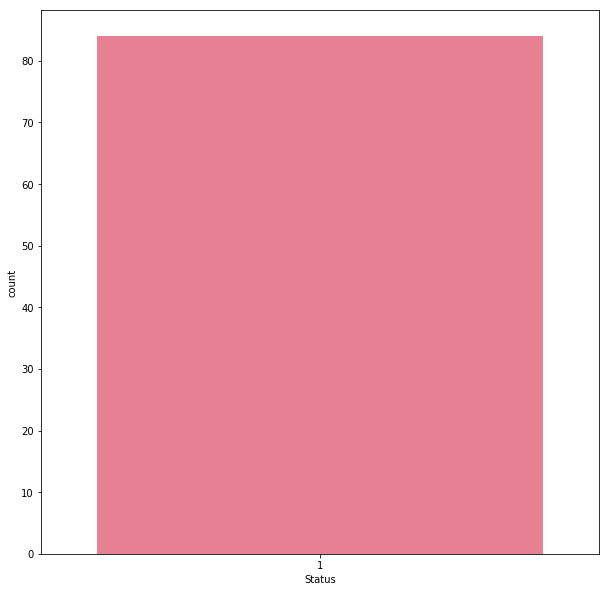

In [21]:
#Check the status
import seaborn as sns

fig = plt.figure(figsize=(10,10))

sns.countplot( (financeData['Status']==1)  , data= financeData['Status'], palette='husl' )

plt.show()

Lets see for the numeric column, on average if there is a pattern in the two classes

In [22]:
#check the means
financeData.groupby('Status').mean()

,Order,Beta,BookValuePerShare,CashFlow,CurrentRatio,D_ERatio,DilutedEPS,EBITDA,EarningsGrowth,EnterpriseValue,...,ReturnonEquity,Revenue,RevenueGrowth,RevenuePerShare,SharesShort(asof,ShortRatio,TotalCash,TotalCashPerShare,TotalDebt,TrailingP_E
Status,,,,,,,,,,,,,,,,,,,,,
0,98.789062,1.285398,17.732094,4.348817e+09,2.473586,34.317039,2.231031,10.977414,67.462500,2.173695e+10,...,16.231094,2.539922,12.945312,50.456711,1.228773e+06,2.808336,2.607906e+09,5.285383,4.173707e+09,31.685625
1,115.726190,1.084179,20.987821,5.986524e+09,1.986310,36.818917,2.942274,15.701548,55.363095,2.345714e+10,...,17.640357,3.648452,19.491667,41.012524,7.797500e+05,3.320131,1.968525e+09,5.057857,3.615527e+09,30.788690


End of the means of status evaluation. Will use this method below to evaluate means between EBITDA and others.

 We set the Order column as index

In [23]:
# Set Order column as index
financeData.set_index('Order', inplace=True)

#sample data
winData.set_index('Order', inplace=True)

## DATA OBSERVATION ##

The target column is 'EBITDA'. We can display the correlation between column 'EBITDA' to the other column.

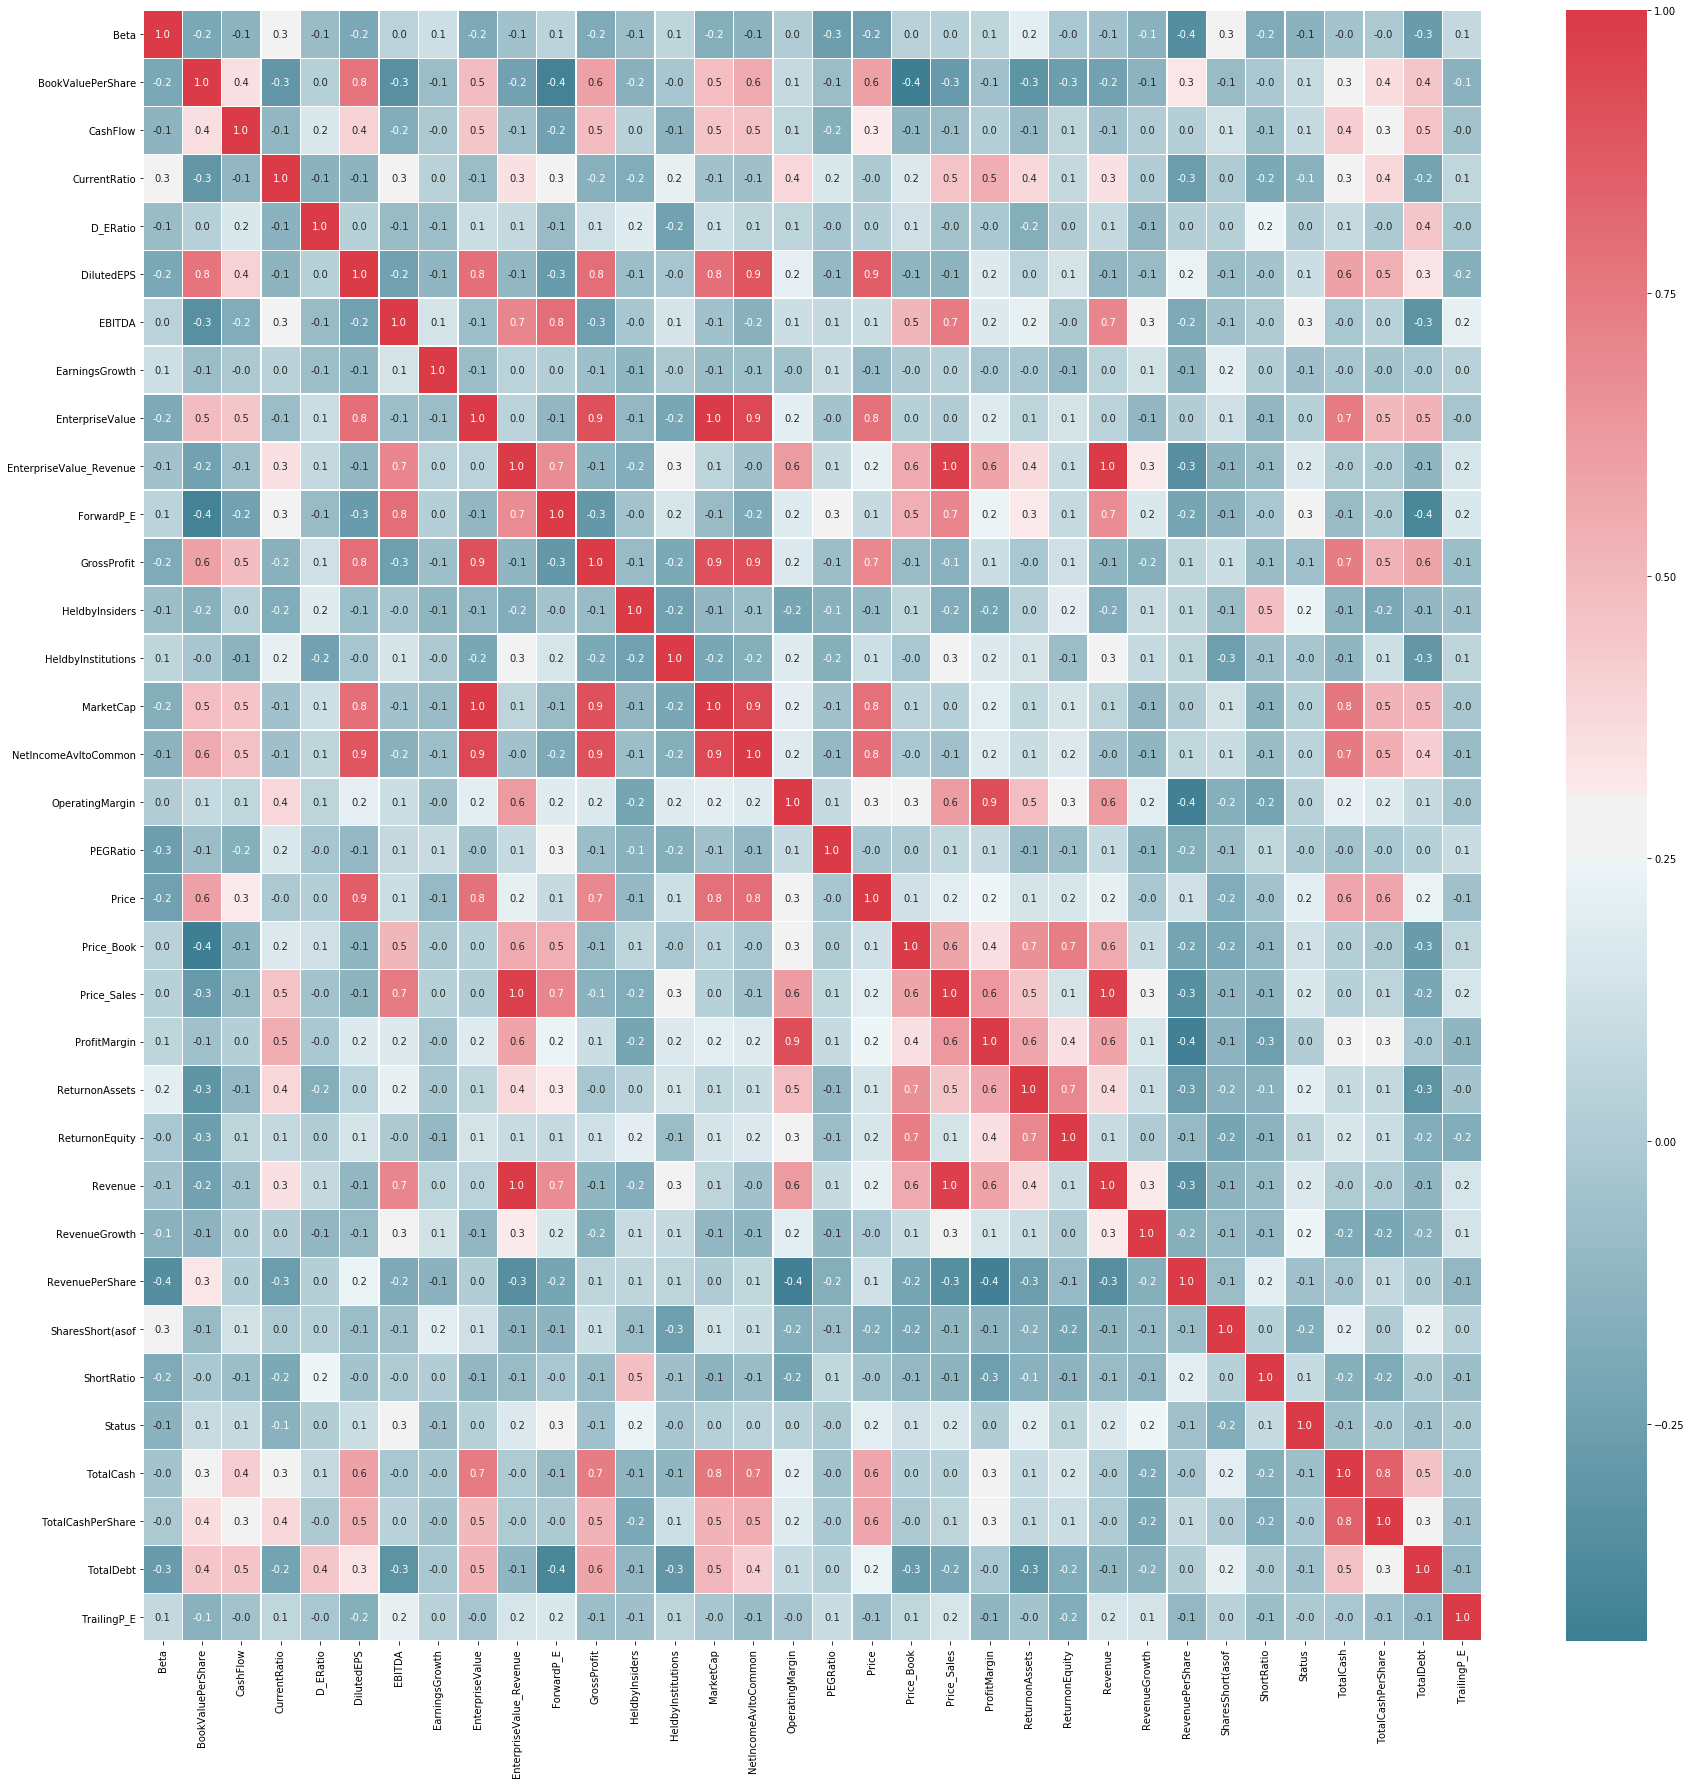

In [24]:
# Display the correlation heatmap

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(1,1,1)
colormap = sbn.diverging_palette(220, 10, as_cmap=True)
sbn.heatmap(financeData.corr(), cmap=colormap, annot=True, linewidths=.4, fmt='.1f', ax=ax)

In [25]:
#The price-to-earnings ratio (P/E ratio) is the ratio for valuing a company that measures its current share price relative to its per-share earnings (EPS). The price-to-earnings ratio is also sometimes known as the price multiple or the earnings multiple.


# Sorted the most important features correlated to EBITDA
corr = financeData.corr()
corr.sort_values(["EBITDA"], ascending = False, inplace = True)
print("Most important feature correlated to EBITDA ")
print(corr.EBITDA)

Most important feature correlated to EBITDA 
EBITDA                     1.000000
ForwardP_E                 0.797076
Price_Sales                0.741501
Revenue                    0.705697
EnterpriseValue_Revenue    0.705697
Price_Book                 0.514275
CurrentRatio               0.292691
RevenueGrowth              0.266500
Status                     0.253766
ReturnonAssets             0.219736
TrailingP_E                0.218175
ProfitMargin               0.178844
HeldbyInstitutions         0.148569
EarningsGrowth             0.142716
Price                      0.114685
OperatingMargin            0.110889
PEGRatio                   0.079704
Beta                       0.047833
TotalCashPerShare          0.038171
ShortRatio                -0.001945
ReturnonEquity            -0.004231
TotalCash                 -0.021583
HeldbyInsiders            -0.030718
MarketCap                 -0.052715
SharesShort(asof          -0.058249
EnterpriseValue           -0.069663
D_ERatio           

Based on correlation heatmap above, some features which has high correlation with 'EBITDA' as above.

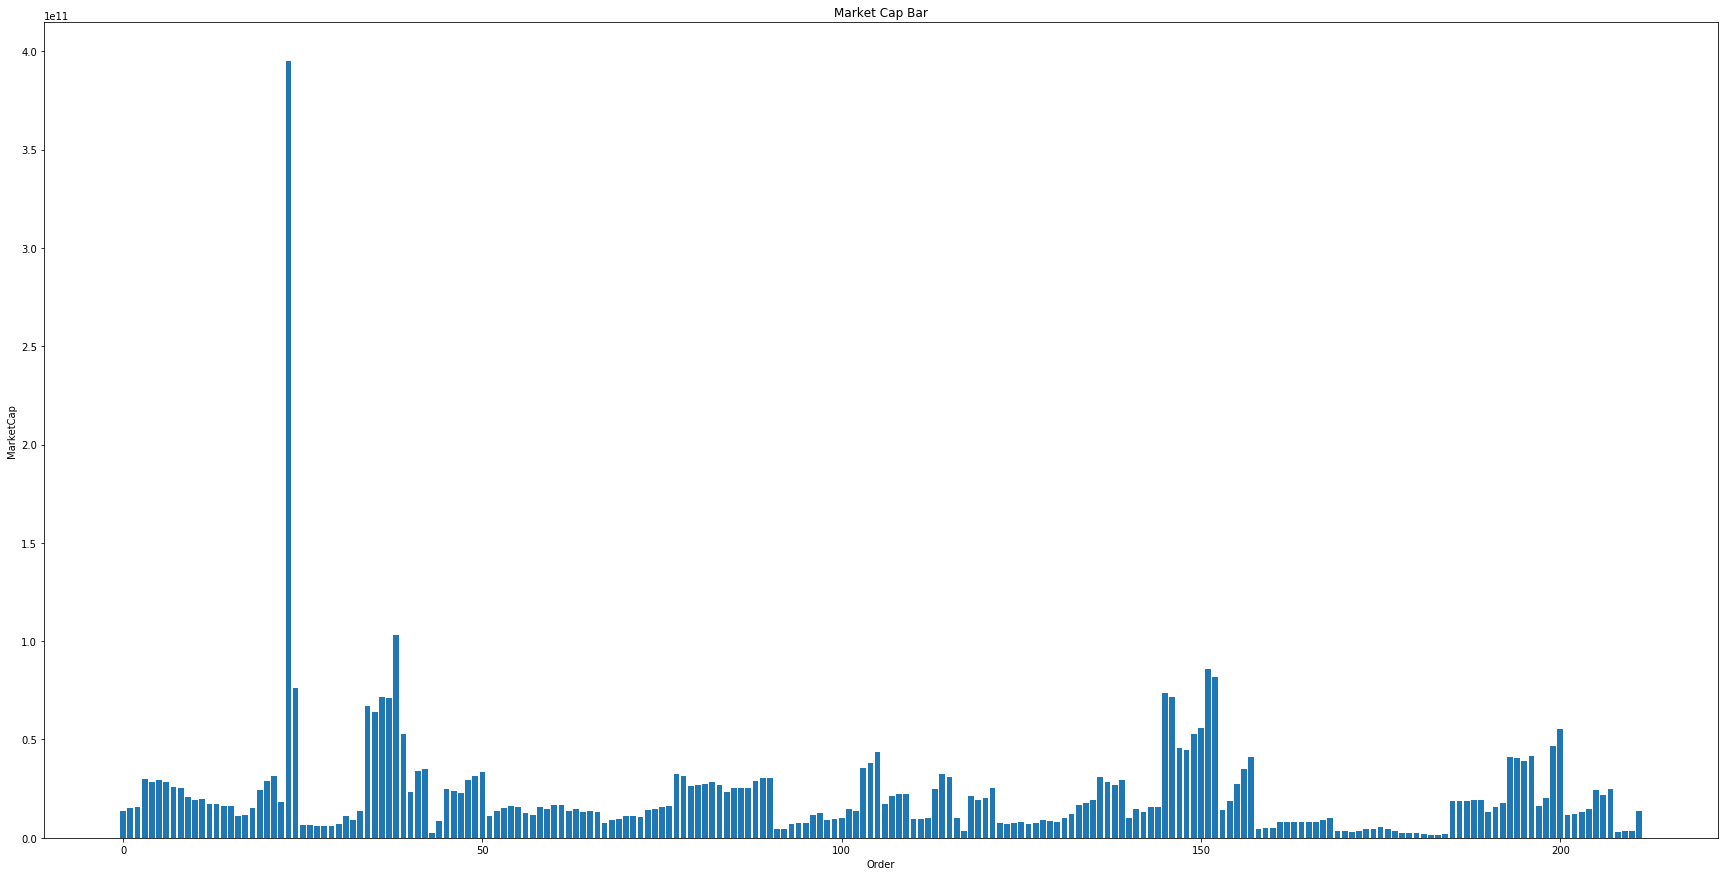

In [26]:
x=[i for i in range(0,212)]  #finance.shape size is 212 *4 
fig = plt.figure(figsize=(30,15))
plt.bar( x , height= financeData.MarketCap )
plt.title("Market Cap Bar")
plt.xlabel("Order")
plt.ylabel("MarketCap")
plt.show()

In [27]:
# Show the correlation summary
financeData.corr()
#define the import correlation features
CORR_Features = ['ShortRatio','ReturnonEquity','TotalCash','HeldbyInsiders','MarketCap', 'SharesShort(asof','EnterpriseValue',
                 'D_ERatio','NetIncomeAvltoCommon', 'CashFlow', 'RevenuePerShare','DilutedEPS','GrossProfit','TotalDebt','TotalDebt'
                 ]

            
#filter the correlation
financeData.drop(CORR_Features, inplace=True, axis=1)

#sample
winData.drop(CORR_Features, inplace=True, axis=1)

#list sample 10
financeData.loc[:, ].sample(10)

,Beta,BookValuePerShare,CurrentRatio,EBITDA,EarningsGrowth,EnterpriseValue_Revenue,ForwardP_E,HeldbyInstitutions,OperatingMargin,PEGRatio,Price,Price_Book,Price_Sales,ProfitMargin,ReturnonAssets,Revenue,RevenueGrowth,Status,TotalCashPerShare,TrailingP_E
Order,,,,,,,,,,,,,,,,,,,,
196,1.780,76.870,0.900,3.37,43.8,2.48,8.27,83.60,41.43,1.25,81.00,1.01,1.81,11.89,7.73,2.48,1.6,1,0.41,16.56
168,0.940,14.730,1.040,13.08,13.7,0.62,13.93,2.60,4.20,0.79,45.00,3.11,0.35,2.03,6.26,0.62,12.0,1,0.38,17.36
83,1.073,9.526,1.553,14.61,7.5,3.50,26.42,72.48,19.84,2.93,45.70,4.92,3.65,12.40,4.31,3.50,2.0,0,2.08,29.11
2,1.810,14.460,2.960,11.93,30.9,2.32,15.09,83.50,14.04,2.16,47.00,3.31,2.32,13.73,5.98,2.32,4.1,0,7.04,17.74
24,1.810,1.870,2.210,9.69,9.6,4.11,13.48,6.30,36.65,2.05,43.00,23.32,3.72,28.92,18.41,4.11,3.7,0,4.72,12.88
81,0.770,27.810,1.840,8.67,31.0,0.31,9.70,8.10,2.58,1.11,27.00,0.98,0.20,1.48,3.36,0.31,5.4,1,1.89,13.83
181,1.540,13.520,3.412,5.85,25.9,0.88,12.25,95.00,11.94,0.85,25.48,1.90,1.05,7.07,10.72,0.88,15.0,0,4.86,15.04
99,0.107,28.576,1.598,8.13,37.2,2.78,15.74,54.90,23.14,5.77,48.01,1.68,1.96,11.10,3.74,2.78,19.6,1,2.63,15.31
73,0.397,12.075,1.605,10.67,9.7,0.47,14.25,65.48,2.52,2.28,21.23,1.76,0.37,1.64,3.15,0.47,17.7,1,2.17,22.59


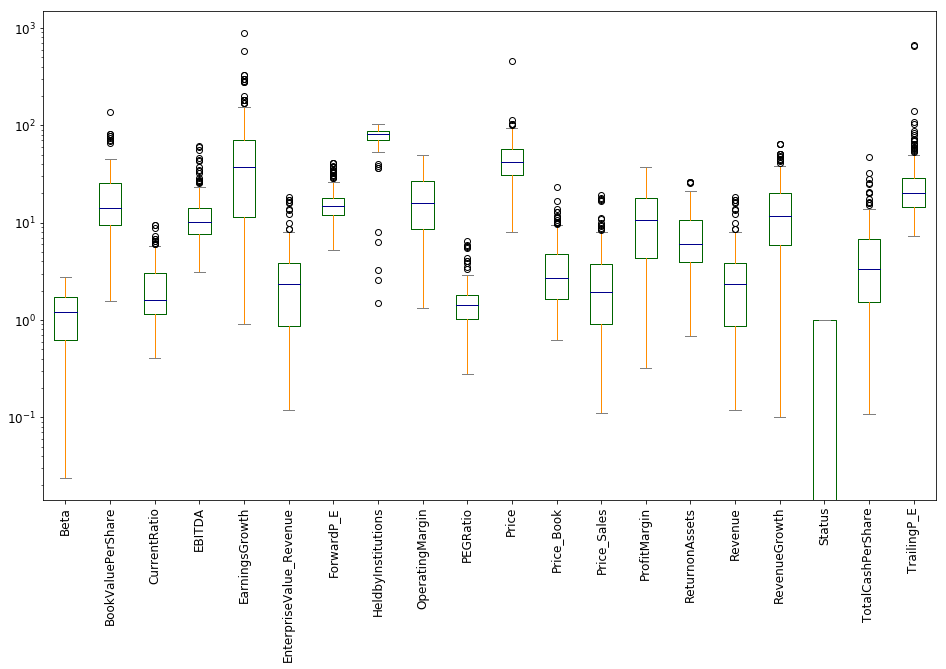

In [28]:
#Drop 'Status'
#financeData.drop(['Status'], inplace=True, axis=1)
#draw box chart
color = dict(boxes  = 'DarkGreen',whiskers = 'DarkOrange',medians = 'DarkBlue',caps ='Gray')
financeData.plot(kind='box', figsize=(16, 9), rot=90, logy=True, fontsize=12,color =color);

We try to get some information from the dependant variable  (column 'financeData').

In [29]:
# Get information from column 'EBITDA'
# We will see that the EBITDA minimum value is greater than zero.
financeData['EBITDA'].describe()

count    212.000000
mean      12.849241
std        9.126926
min        3.090000
25%        7.670000
50%       10.215000
75%       14.272500
max       61.540000
Name: EBITDA, dtype: float64

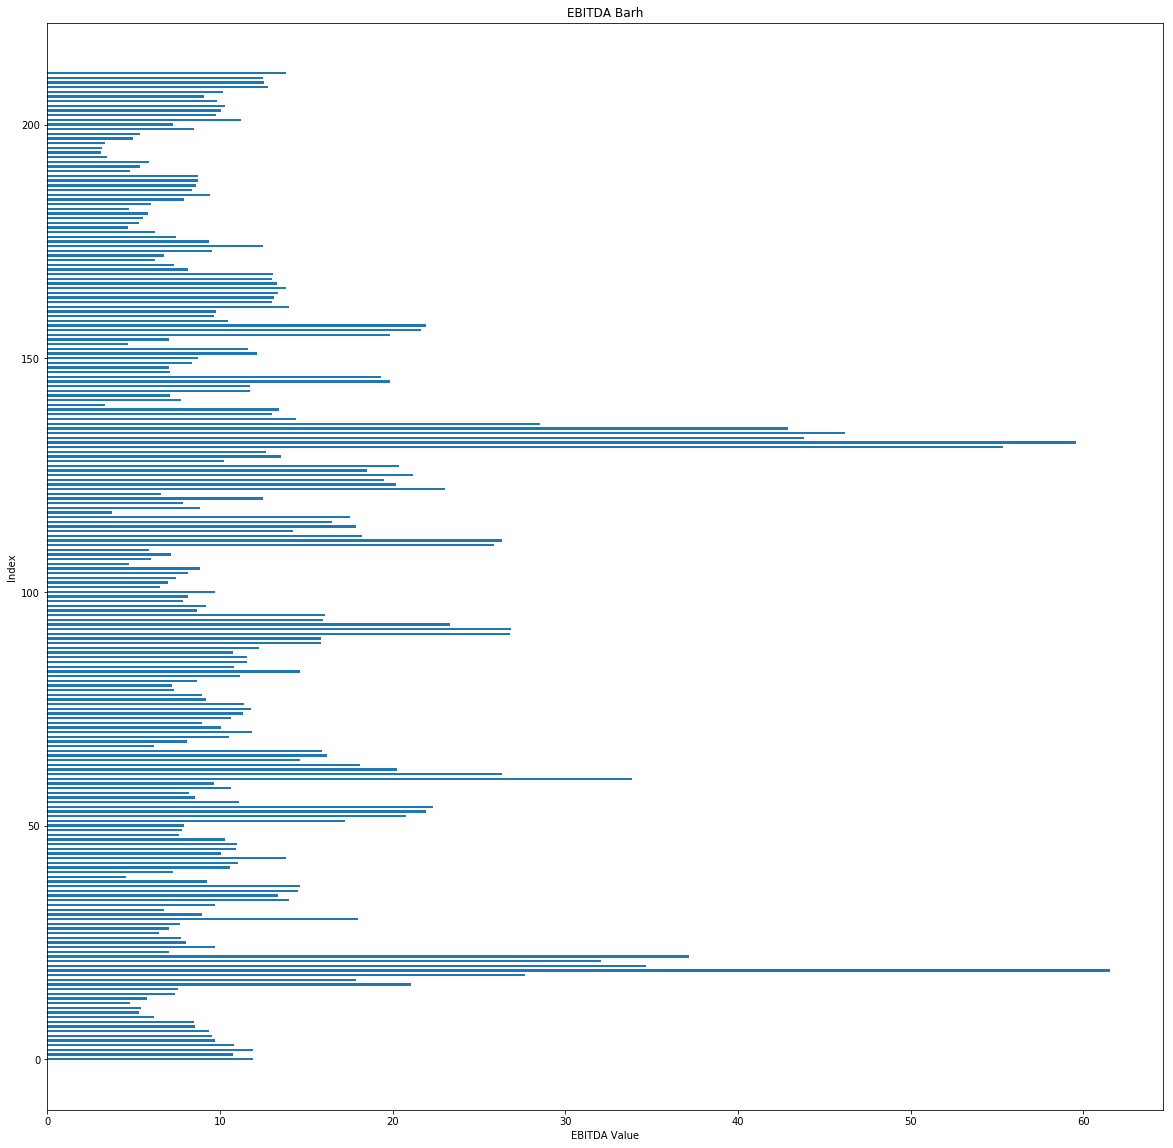

In [30]:
#special show the barh chart of EBITDA
uu=[i for i in range(0,212)]  #finance.shape size is 212 *4 
fig = plt.figure(figsize=(20,20))
#plt.barh( bottom =x , height= financeData.EBITDA )
# 绘图 x= 起始位置， bottom= 水平条的底部(左侧), y轴， height 水平条的宽度， width 水平条的长度
plt.bar(x=0, bottom=uu, height=0.5, width=financeData.EBITDA, orientation="horizontal")


#financeData.plot(kind='barh', figsize=(30, 15), rot=90, logy=True, fontsize=12);
plt.title("EBITDA Barh")
plt.xlabel("EBITDA Value")
plt.ylabel("Index")
plt.show()

We plot column 'EBITDA' with the top three features (as our example) which has highest correlation from correlation heatmap, to get better understanding.

Draw the scatter to see any outliers in the dataframe financeData. Now we plot EBITDA with  Forward P/E.<br>
From the picture below, we can see that there are 5 outliers in the dataframe. The outlier tells us that there are 5 data with very large Forward P/E but having very low EBIDA. That means deviation.
#######?????whether to replaced the boolean value as the main corr value ????     
#####?We decide to remove these outliers to make a good prediction later on.
#already means one clustering method,if need output the clustering.

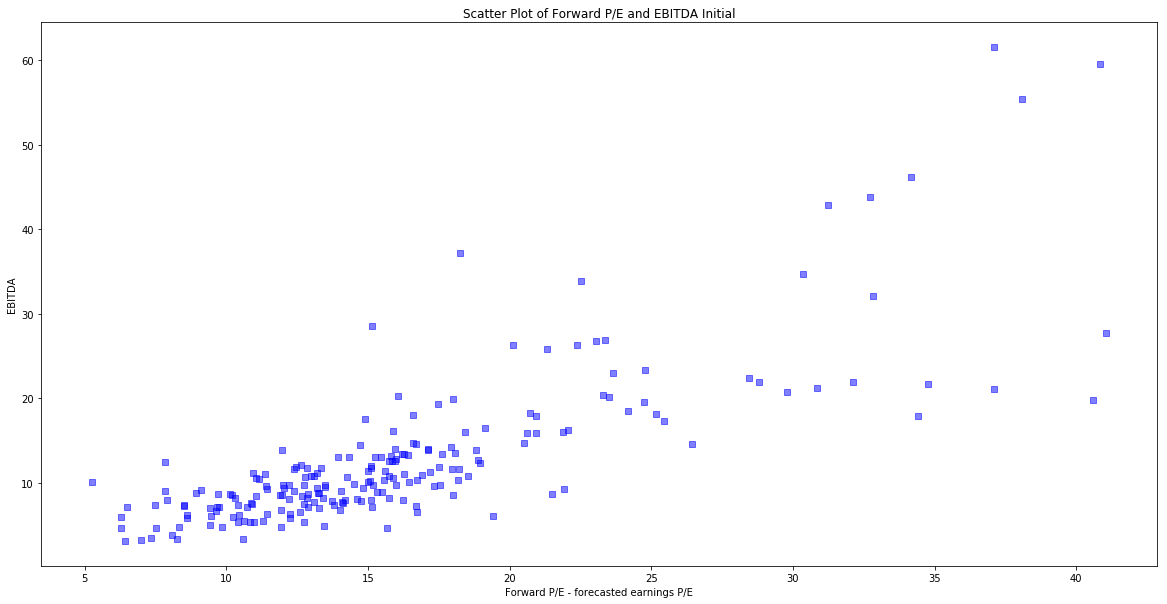

In [31]:
# Looking for outliers
fig = plt.figure(figsize=(20,10))
plt.scatter(x = financeData.ForwardP_E, y = financeData.EBITDA, alpha=0.5, color='blue', marker = "s")

plt.title("Scatter Plot of Forward P/E and EBITDA Initial")
plt.xlabel("Forward P/E - forecasted earnings P/E")
plt.ylabel("EBITDA")
plt.show()

In [32]:
financeData['Status'].sample(10)
# Remove these outliers to make a good prediction later on
#financeData = financeData.drop(financeData[(financeData['ForwardP_E']>33) & (financeData['EBITDA']<30)].index)
#financeData = financeData.drop(financeData[(financeData['Status']==0) ].index)
#financeData = financeData.drop(financeData[(financeData['Status']==1) ].index)


Order
47     0
186    0
192    1
0      0
184    0
58     0
180    0
37     0
203    1
125    1
Name: Status, dtype: int64

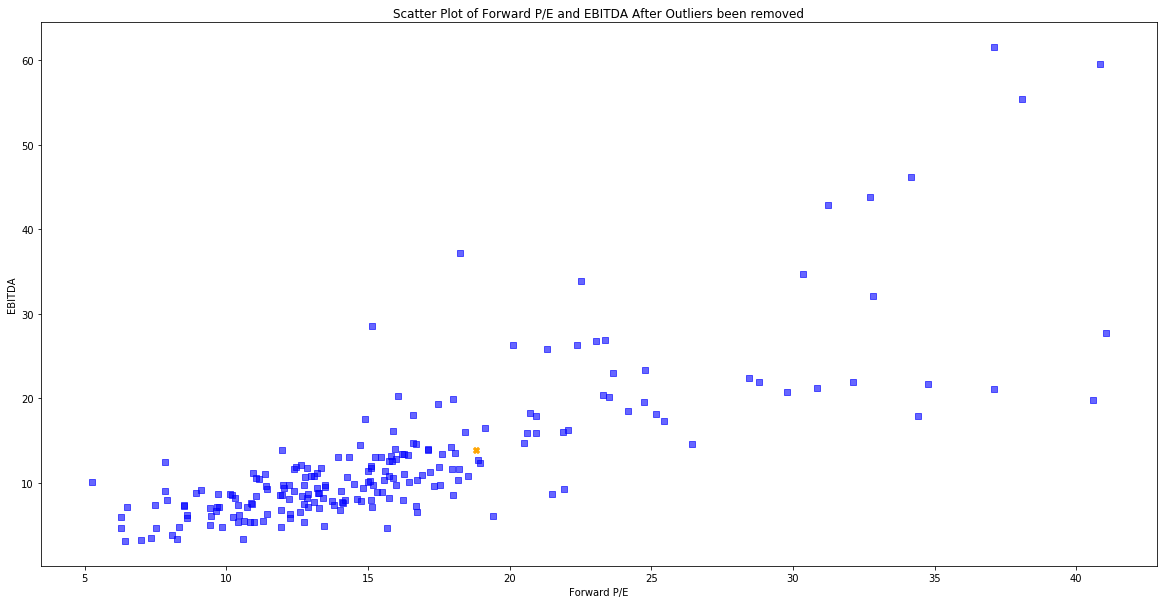

In [33]:
# Display the graph after 5 outliers have been removed
#filter ,then draw
fig = plt.figure(figsize=(20,10))
plt.scatter(x = financeData.ForwardP_E[:-2], y = financeData.EBITDA[:-2],alpha=0.6, color='blue', marker = "s" )
plt.title("Scatter Plot of Forward P/E and EBITDA After Outliers been removed")
plt.xlabel("Forward P/E")
plt.ylabel("EBITDA")

#show the last data with special color
plt.scatter(x=financeData.ForwardP_E[-1:], y = financeData.EBITDA[-1:], marker='X', color='orange')
plt.show()

Now we plot EBITDA with 'Price_Sales' (Rates the overall and finish of current PriceSales).
From the picture below, we can see that if the company is having better overal Price Sales, then the EBITDA will also better.

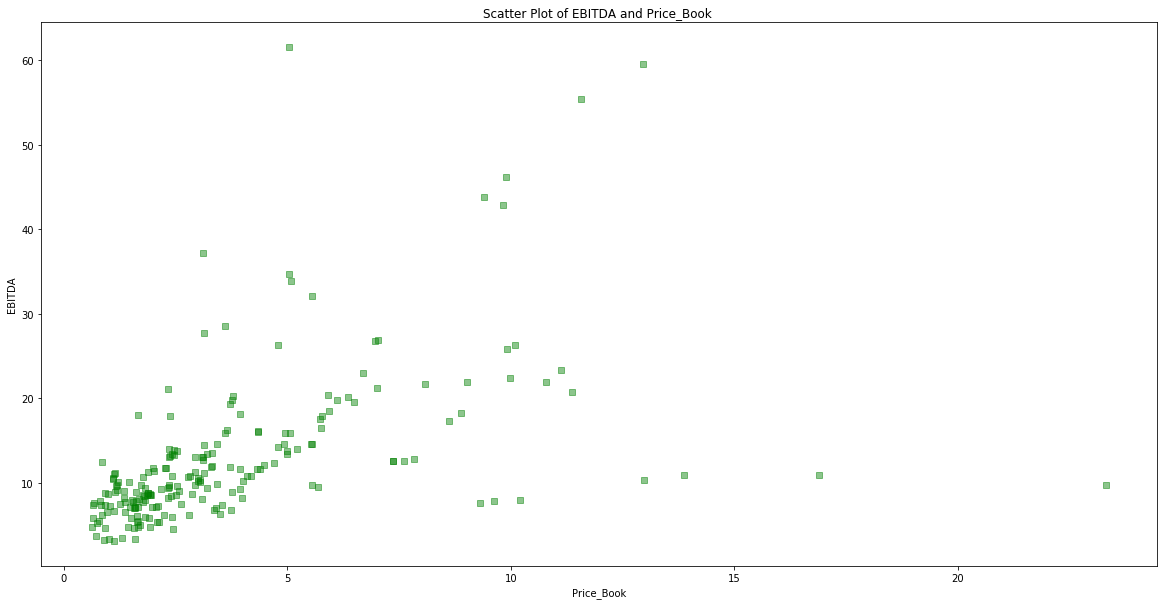

In [34]:
# Plot 'EBITDA' and 'Price_Book' 
fig = plt.figure(figsize=(20,10))
plt.scatter(x = financeData.Price_Book, y = financeData.EBITDA, alpha=0.45, color='green', marker = "s")
plt.title("Scatter Plot of EBITDA and Price_Book ")
plt.xlabel("Price_Book")
plt.ylabel("EBITDA")
plt.show()

We now plot EBITDA with 'Revenue' (Evaluates the Revenue).
From the picture below, we can see that if the company is having better Revenue,then the EBITDA will also better.

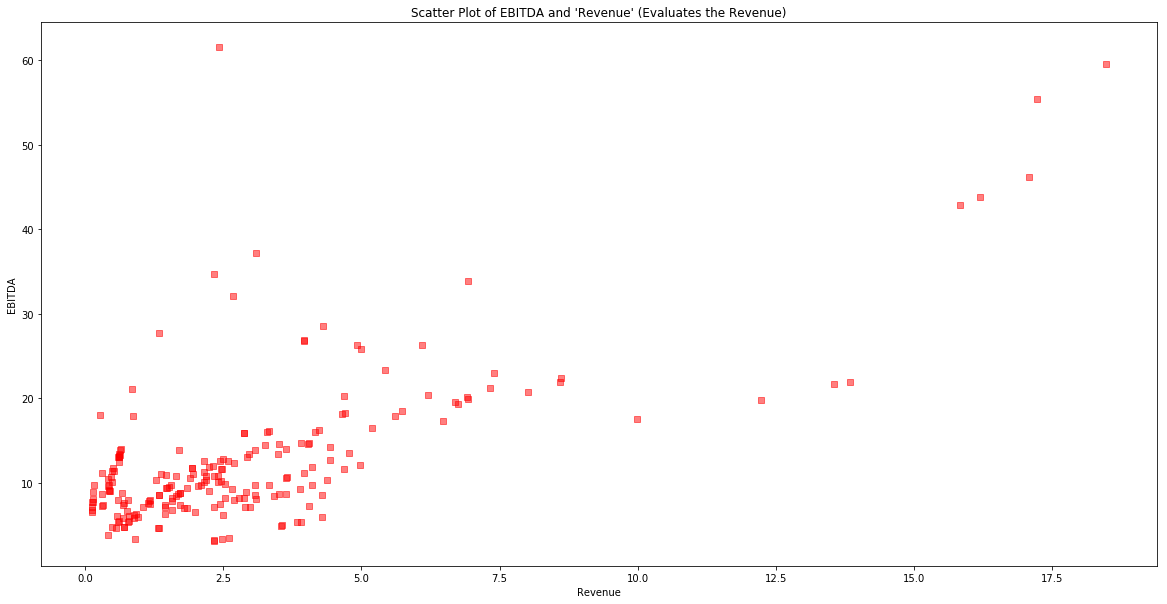

In [35]:
# Plot 'EBITDA' and 'Revenue' (Evaluates theRevenue).
fig = plt.figure(figsize=(20,10))
plt.scatter(x = financeData.Revenue, y = financeData.EBITDA, alpha=0.5, color='red', marker = "s")
plt.title("Scatter Plot of EBITDA and 'Revenue' (Evaluates the Revenue)")
plt.xlabel("Revenue")
plt.ylabel("EBITDA")
plt.show()

We see the distribution of  values (EBITDA)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


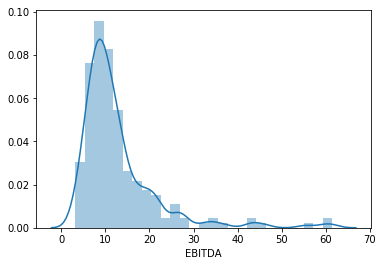

In [36]:
# Check the distribution of  values (EBITDA)
sbn.distplot(financeData['EBITDA'])


In [37]:
# Skewness metric
financeData['EBITDA'].skew()

2.7455849235453527

The skewness value > 1 ==> data is highly skewed. (Ref: https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55 ). We can use Logarithm transformation to normalize the EBITDA data. A normalized label helps in better modeling the relationship between label values and independent features.

In [38]:
normalized_ebitda = np.log(financeData['EBITDA'])
print('Check skewness:', normalized_ebitda.skew())

Check skewness: 0.5691073071417297


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


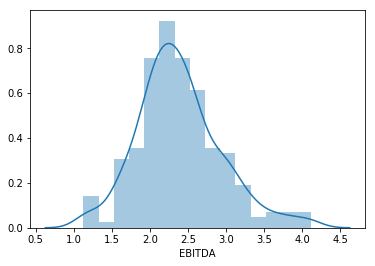

In [39]:
sbn.distplot(normalized_ebitda)

In [40]:
# We check the type of all columns in dataframe financeData
financeData.dtypes

Beta                       float64
BookValuePerShare          float64
CurrentRatio               float64
EBITDA                     float64
EarningsGrowth             float64
EnterpriseValue_Revenue    float64
ForwardP_E                 float64
HeldbyInstitutions         float64
OperatingMargin            float64
PEGRatio                   float64
Price                      float64
Price_Book                 float64
Price_Sales                float64
ProfitMargin               float64
ReturnonAssets             float64
Revenue                    float64
RevenueGrowth              float64
Status                       int64
TotalCashPerShare          float64
TrailingP_E                float64
dtype: object

## Divide the financeData into trainset and testset, then normalize x_train an x_test by using StandardScaler

In [41]:
# We use sklearn.model_selection import train_test_split to split the dataframe into trainset and testset
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
   
#Divide data into training set and test set = 80 % : 20%
trainset, testset = train_test_split(financeData, test_size=0.2)

# Convert all columns with type integer (except EBITDA) to float 32 to save some memory.
trainset = trainset.astype('float32')
testset = testset.astype('float32')
    
x_trainset = trainset.drop(['EBITDA'],axis=1)
x_testset = testset.drop(['EBITDA'],axis=1)
 
scaler = StandardScaler()

x_train = scaler.fit_transform(trainset.drop(['EBITDA'],axis=1).values)
y_train = scaler.fit_transform(trainset['EBITDA'].values.reshape(-1, 1))
y_train = np.ravel(y_train)

x_test = scaler.fit_transform(testset.drop(['EBITDA'],axis=1).values)
y_test = scaler.fit_transform(testset['EBITDA'].values.reshape(-1, 1))
y_test = np.ravel(y_test)

## GA_ANN Algorithm

**Step 1 Initial population function**

In [42]:
# Initial population function
# pop_size is the number of individuals (rows) in the initial population
# genesPerCh is the number of genes per each individual (features/ columns) 

def generate_pop (pop_size, genesPerCh):                   # assign randomly binary values to each individual
    chromosomes = np.array([np.random.choice([0,1], size=genesPerCh)for individual in range(pop_size)],dtype='int8')   
    return chromosomes   # return the initial population

**Step 2 Decode Function**

In [43]:
# Decode function
# pop is the population to be decoded
# np.argwhere return indices from non-zero genes and flattened the array with np.ravel
def decode_function(pop): 
    selected_features = np.array([np.ravel(np.argwhere(pop[i])) for i in range(pop.shape[0])])
    return selected_features         # return array with selected indices 

**Step 3 ANN Functions**

In [44]:
#ANN with SKlearn
from sklearn.neural_network import MLPRegressor  

def NeuralNetwork(train_x, train_y):
    mlp = MLPRegressor(hidden_layer_sizes=(10),
                       activation='relu',
                       solver='lbfgs',
                       max_iter=1,
                    )
 
    mlp.fit(train_x, train_y)  
    return mlp

def get_predictions_forTrain(features):
    #print("yourfeature:"+str(features))
    #for given feature indexes, this function will get predictions from neural network for the specified features
    mlp = NeuralNetwork(x_train[:,features], y_train)
    predictions = mlp.predict(x_train[:,features])
    return predictions

**Step 4 Fitness Function**

In [45]:
def fitness(pred, real):
    MSE_ANN = mean_squared_error(real , pred)
    RMSE_ANN = np.sqrt(MSE_ANN)
    return (1/RMSE_ANN) #fitness would be the inverse of roo mean square error

#### Step 5 Stopping criteria Fuction

In [46]:
def stoppingCriteria(fitness, pop, fitness_of_featuresSets, n):
    #This functions stops the iteration if after 20x5 iterations, the fitness drops, it takes the population from previous fitness STORED
    global temp_pop #The population which will be used as 
    global temp_fitness
    if len(fitness) < n: #No stopping until we reach nx5 iterations 
        return False
    elif len(fitness) == n: #At nx5th iteration, store the population and its fitness
        temp_pop = pop
        temp_fitness = fitness_of_featuresSets
        return False
    else:
        if fitness[-2] < fitness[-1]: #this means that fitness is increased after 5 iterations
            #keep on storing the latest population and respective fitness PASSED
            #This process can be complicated by using the n-5th and n-10th fitness value, but sometimes, it would take more iteration but the same best fitness
            temp_pop = pop
            temp_fitness = fitness_of_featuresSets
            return False
        else: #if it drops from the value 5 iterations before, stop the process
            return True #return true only when it is smaller than previous one. Temp_pop will be the previous population

**Step 6 Roulette Wheel Selection Function**

In [47]:
def RouletteWheel_Selection(pop,fitness):
    porps = (fitness/np.sum(fitness))  # calculate the proportions of all fitnesses   
    fitness_pop = np.hstack([pop,porps]) # add the proportions to population
    new_parents = np.zeros(pop.shape,dtype='int8')
    for chromosome in range(new_parents.shape[0]) :
        pick = np.random.uniform(0,1)         # pick random number from 0 to summation of proportions
        index = np.argwhere(fitness_pop[:,-1].cumsum()>pick)[0]  # go through the population and sum the fitnesses and 
        new_parents[chromosome] = fitness_pop[index,:-1]         # return the chromosome when the sum of fitnesses is 
                                                                 # greater than pick number
    return new_parents   # return the selected parents 

**Step 7 Uniform Crossover Function**

In [48]:
def uniformCrossover(population):
    offspring = np.zeros_like(population)
    p1 = population[::2] #Even indexes 0,2,4... would be parent 1
    p2 = population[1::2] #Odd indexes 1,3,5... would be parent 2
    if len(p1)!=len(p2): #If population size is odd the p1 would be larger thatn p2
        #We won't be doing the crossover of last individual of the mutation pool and copy it as it is to the offspring
        offspring[-1] = p1[-1]
        p1 = p1[:-1]
    swap = np.random.choice([True,False], size=p1.shape) #generate True or False of every parent set.
    #True means swap the cell from p1 with p1. False means no swapping
    #Even rows of offspring would be p1 and odd would be p2
    offspring[:-1:2] = np.where(swap, p2, p1) #if swap is true for a cell, even row would have p2 for that gene. Other-wise p1 
    offspring[1::2] = np.where(swap, p1, p2) #if swap is true for a cell, odd row would have p1 for that gene. Other-wise p2
    return offspring

**Step 8 Mutation**

In [49]:
# Mutiation function with default mutation probability as 0.3
def bitFlipMutation(offspring, p = 0.3):
    toMutate = np.sort(np.random.randint(offspring.shape[0], size=int(offspring.shape[0]*p))) #Select the chromosomes you want to apply Mutation on
    bitPos = np.random.randint(offspring[toMutate].shape[1], size=offspring[toMutate].shape[0]) #generate a random gene position to flip for selected chromosomes
    offspring[toMutate, bitPos] = np.where(offspring[toMutate, bitPos],0,1) #if value is 1, replace it by 0 and vice-versa
    return offspring

**MAIN Part**

In [50]:
pop_size = 100 #size of the initial population
pred_train = np.frompyfunc(get_predictions_forTrain, 1, 1) #Function to get prediction array corresponding to all the slected features in the population
fVec = np.vectorize(fitness, excluded=['real'], otypes=[np.float32]) #vectorized funtion to get the fitness of every individual in the population
finance_features = financeData.columns[:-1] #Names of features
genesPerCh = finance_features.size #genes per chromosome
pop = generate_pop(pop_size, genesPerCh) #Generate initial population. This will be updated in every generation
selected_features = decode_function(pop)
number_of_generations = 201 #the values is set to have mod5 = 1 for a complete plot
avgFitnessPerGeneration = [] #average of fitness values of the individuals in every fifth generation
maxFitnessPerGeneration = [] #maximum of fitness values of the individuals in every fifth generation
minFitnessPerGeneration = [] #minumum of fitness values of the individuals in every fifth generation
for iteration in range(number_of_generations):
    s_predictions = pred_train(selected_features) #predicted labels for train data for each individual in the population
    fitness_of_featuresSets = fVec(pred = s_predictions, real = y_train) #for every predicted array, get the fitness for each individual
    fitness_of_featuresSets = fitness_of_featuresSets.reshape(fitness_of_featuresSets.shape[0],1)  #taking the transpose to get proper dimensions for future computations
    if iteration%5 == 0: #max, min and average values will only be stored for every 5th iteration
        avgFitnessPerGeneration.append(np.mean(fitness_of_featuresSets))
        maxFitnessPerGeneration.append(np.max(fitness_of_featuresSets))
        minFitnessPerGeneration.append(np.min(fitness_of_featuresSets))
        if stoppingCriteria(maxFitnessPerGeneration, pop, fitness_of_featuresSets, n=15): #checking if the stopping criteria is met
            selectedPop = temp_pop #temp pop is selected to get the best individual
            fitnessForSelectedPop = temp_fitness #the corresponding fitness for the population
            indPos = np.argmax(fitnessForSelectedPop) #get the index where the best betness ratio
            bestInd = selectedPop[indPos] #get the best pop corresponding to best fitness
            break  #no more generations if stopping criteria is met
    mating_pool = RouletteWheel_Selection(pop, fitness_of_featuresSets)
    #CrossOver
    offspring = uniformCrossover(mating_pool) 
    #Mutation
    offspring = bitFlipMutation(offspring)
    #updating population for next generation
    pop = offspring
    #updating features for next iteration
    selected_features= decode_function(offspring)

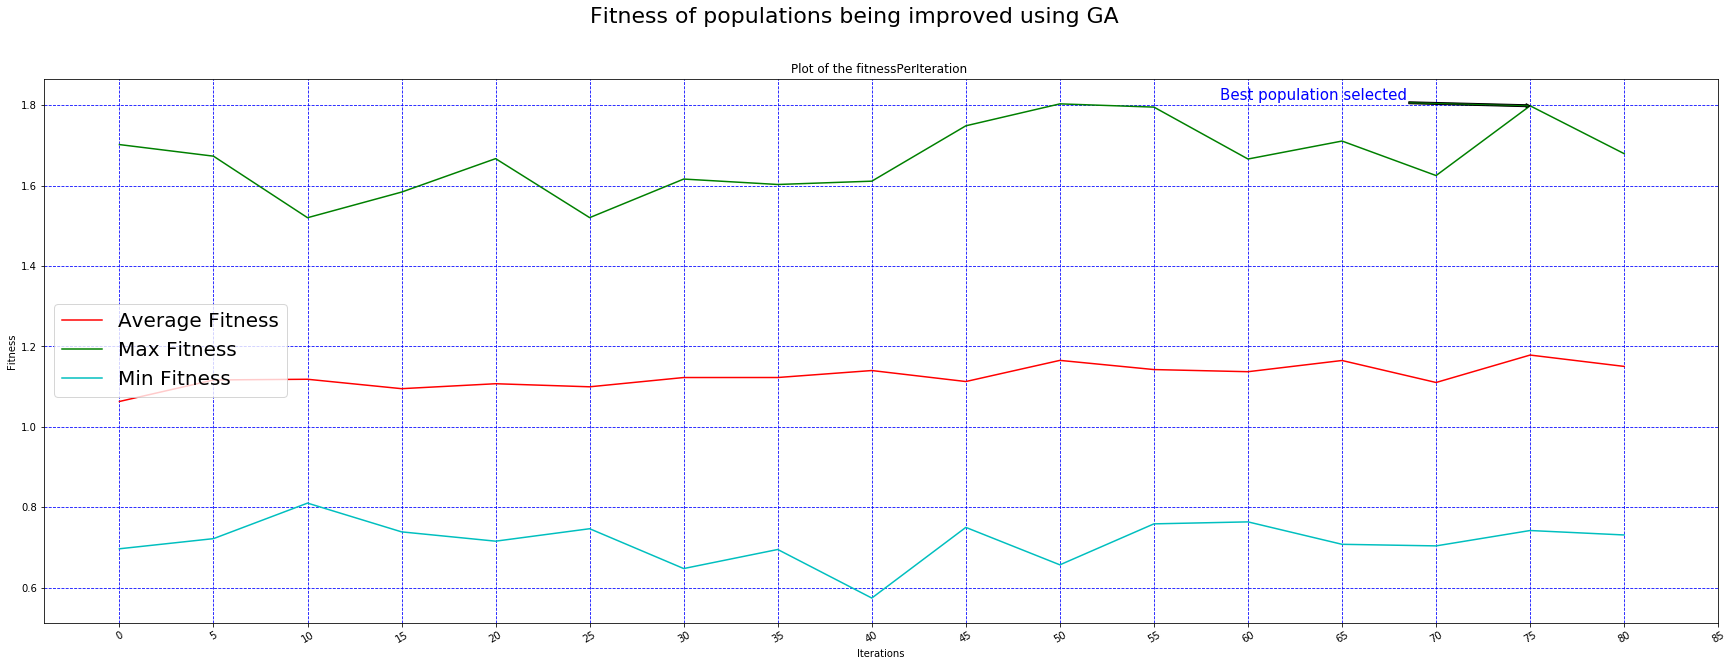

In [51]:
#plot fitnessPerGeneration
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1, 1, 1)
#set title of the graph/plot
ax.set_title('Plot of the fitnessPerIteration ')
#ax.set_xlabel('Date')
ax.plot(avgFitnessPerGeneration, 'r', label='Average Fitness')
ax.plot(maxFitnessPerGeneration, 'g', label='Max Fitness')
ax.plot(minFitnessPerGeneration, 'c', label='Min Fitness')
ax.legend(loc='best', prop={'size': 20}) 
_ = fig.suptitle('Fitness of populations being improved using GA', fontsize=22)
ax.grid(color = 'b', linestyle='--')
xticks = list(range(0,len(maxFitnessPerGeneration)+1,1))
xticklabels = [x*5 for x in xticks]
props = {'xlabel': 'Iterations',
         'xticks': xticks,
         'ylabel': 'Fitness'
        }
_ = ax.set(**props)
labels = ax.set_xticklabels(xticklabels, rotation=30, fontsize='medium')
#Annotation
xh = (len(maxFitnessPerGeneration)-2)
yh = np.max(temp_fitness)
_= ax.annotate('Best population selected', 
                xy = (xh, yh), 
                xytext=(ax.get_xlim()[0]+xh-2.5, yh + 0.045),
                arrowprops=dict(facecolor='green', headwidth=4, width=2,
                                headlength=4),
                horizontalalignment='left', verticalalignment='top', color='blue', size=15
                )

#### The most important features that give the best fitness are:

In [52]:
print(np.ravel(finance_features[np.argwhere(bestInd)]))

['EBITDA' 'EnterpriseValue_Revenue' 'Price_Book' 'ReturnonAssets']


**Evaluate with the test set**

In [53]:
def get_predictions_forTest(features):
    #for given feature indexes, this function will get predictions from neural network for the specified features
    mlp = NeuralNetwork(x_train[:,features], y_train)
    predictions = mlp.predict(x_test[:,features])
    return predictions

In [54]:
# get predictions on testset
pred_test = np.frompyfunc(get_predictions_forTest, 1, 1) #Function to get prediction array corresponding to all the slected features
selected_features_test = decode_function(selectedPop) #get selected features by GA
s_predictions_test = pred_test(selected_features_test) #predicted labels for test set
fitness_of_featuresSets_test = fVec(pred = s_predictions_test, real = y_test) #for every predicted array, get the fitness for each individual
fitness_of_featuresSets_test = fitness_of_featuresSets_test.reshape(fitness_of_featuresSets_test.shape[0],1)  #taking the transpose to get proper dimensions for future computations

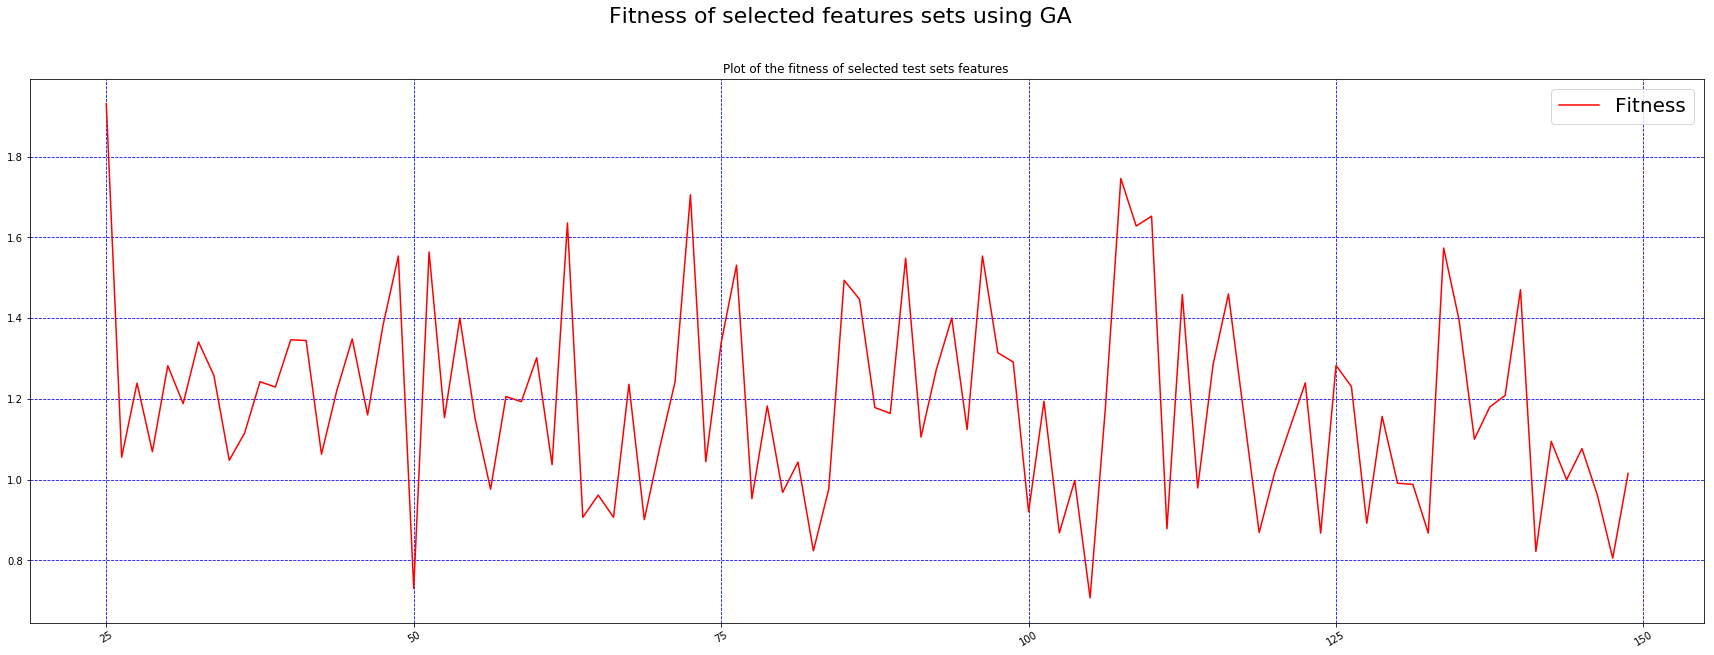

In [55]:
#plot fitness_of_featuresSets_test
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1, 1, 1)
#set title of the graph/plot
ax.set_title('Plot of the fitness of selected test sets features ')

ax.plot(fitness_of_featuresSets_test, 'r', label='Fitness')
ax.legend(loc='best', prop={'size': 20}) 
_ = fig.suptitle('Fitness of selected features sets using GA', fontsize=22)
ax.grid(color = 'b', linestyle='--')
xticks = list(range(0,len(fitness_of_featuresSets_test)+1,5))
xticklabels = [x*5 for x in xticks]

labels = ax.set_xticklabels(xticklabels, rotation=30, fontsize='medium')

In [56]:
# Denormalize data after normalizing to get original scale of values

def denormalize(dataset, scaled_data):
    dataset = dataset['EBITDA'].values.reshape(-1,1)
    normalized_data = scaled_data.reshape(-1,1)
    scaler = StandardScaler()
    scaler.fit_transform(dataset)
    return scaler.inverse_transform(normalized_data)

In [57]:
# denormalize y test and predictions
de_y_test = denormalize(testset, y_test)
de_pred = denormalize(testset, s_predictions_test)
# de_pred = np.abs(de_pred)
# make the predictions array flat
fitness_values = np.ravel(fitness_of_featuresSets_test)

de_pred_max = de_pred[np.argmax(fitness_values)][0] # predictions with max fitness in selected features set
de_pred_min = de_pred[np.argmin(fitness_values)][0] # and min fitness

# index of fitness value that's nearest to the average fitness of selected features set
average_idx = (np.abs(fitness_values - np.average(fitness_values))).argmin()
de_pred_average = de_pred[average_idx][0]

In [58]:
def plot_test_result(pred, test_y, fra=0, color='blue', label='predictions'):
    #Plotting real value against prediction value over a period
    fig = plt.figure(1, figsize=(20,12))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("EBITDA indicator's Prediction", fontsize=20)
    ax.plot(test_y[fra:], color='red', label='real', linewidth=3)
    ax.plot(pred[fra:], color=color, label=label, linewidth=3)
        
    ax.legend(loc='best')
    plt.ylabel('EBITDA')
    plt.show()

In [59]:
def mse_result(test, pred):
    MSE = mean_squared_error(test , pred) 
    RMSE = np.sqrt(MSE)
    fitness = 1/RMSE
    print("MSE %.4f"% MSE)
    print("RMSE %.4f"% RMSE)
    print("Fitness %.8f"% fitness)

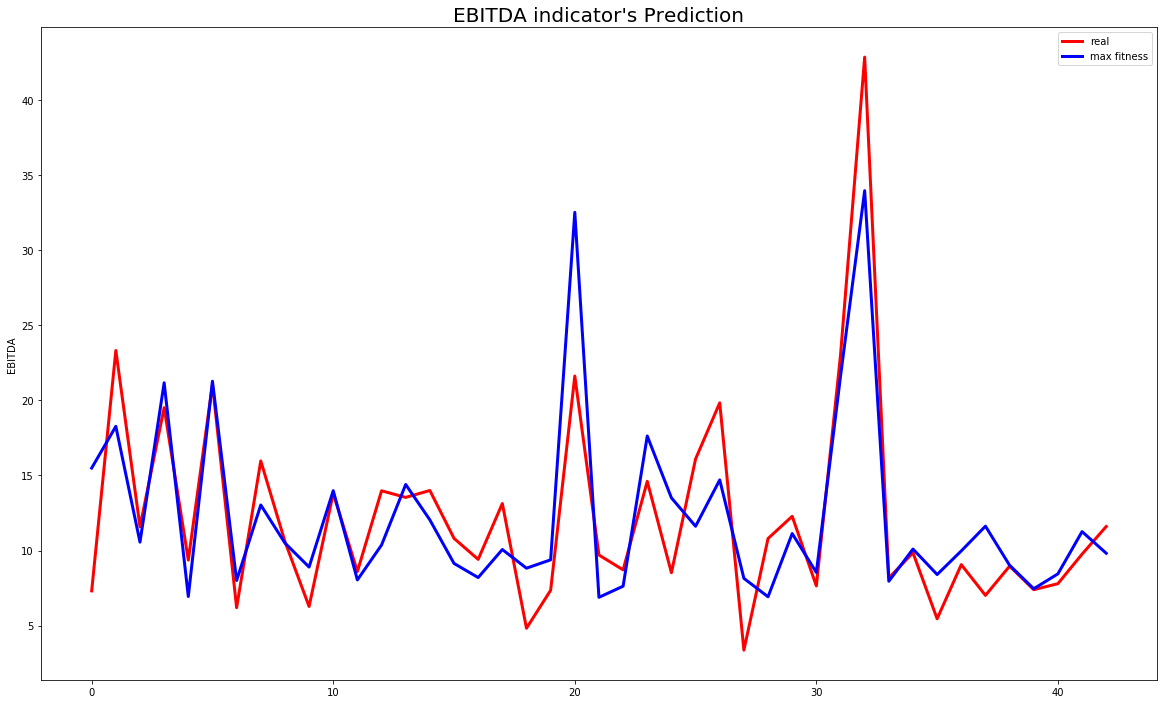

In [60]:
plot_test_result(de_pred_max, de_y_test, fra=0, label='max fitness')

In [61]:
mse_result(de_y_test , de_pred_max)

MSE 12.5478
RMSE 3.5423
Fitness 0.28230393


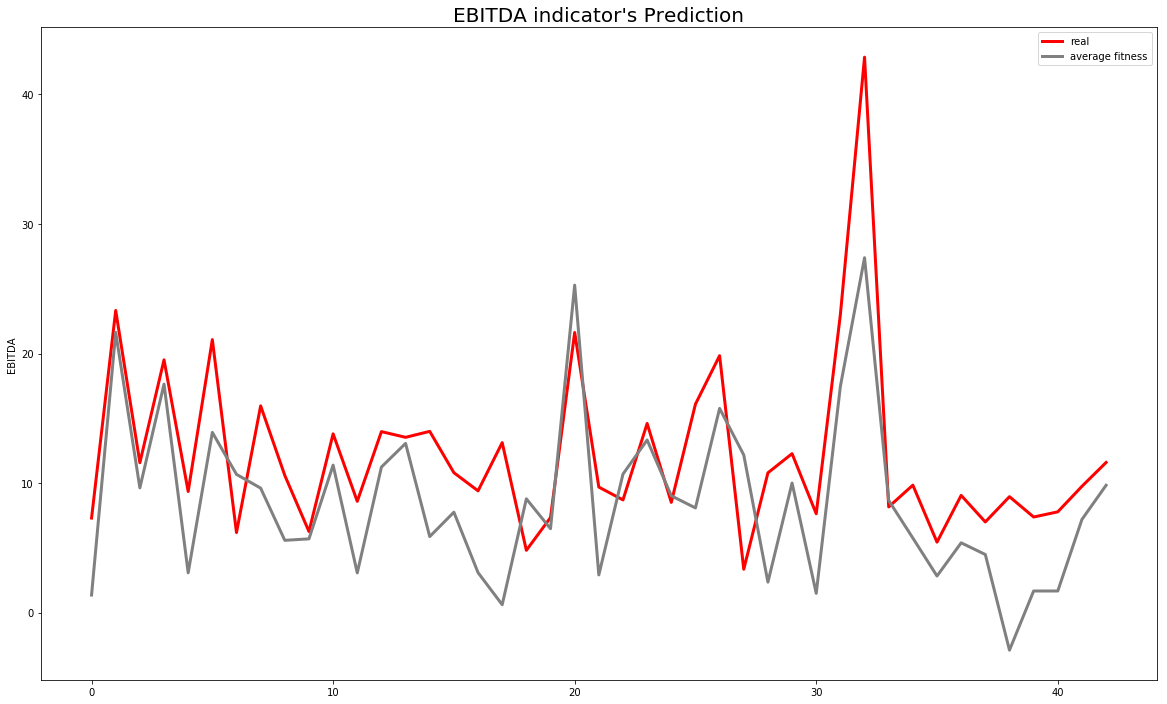

In [62]:
plot_test_result(de_pred_average, de_y_test, fra=0, color='gray', label='average fitness')


In [63]:
mse_result(de_y_test , de_pred_average)

MSE 33.1476
RMSE 5.7574
Fitness 0.17368968


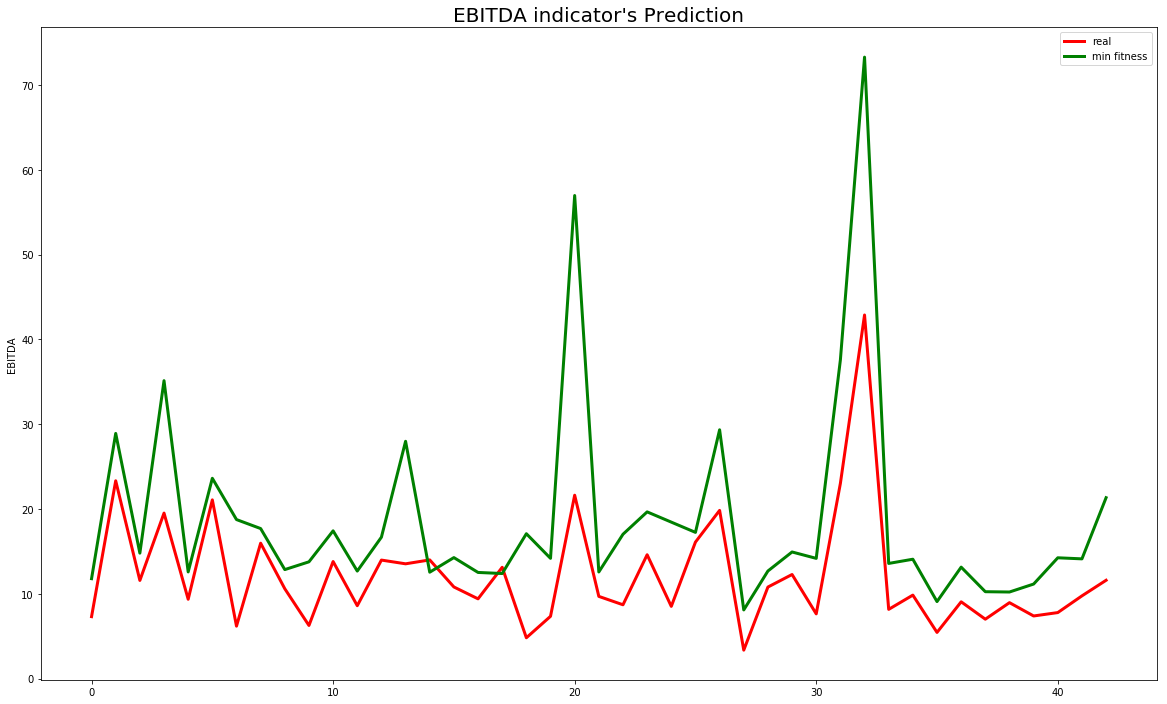

In [64]:
plot_test_result(de_pred_min, de_y_test, fra=0, color='green', label='min fitness')

In [65]:
mse_result(de_y_test , de_pred_min)

MSE 93.6114
RMSE 9.6753
Fitness 0.10335599


### Finance prices's prediction without feature selection:

In [66]:
# create mlp model, then we fit the training data to the model and we use x_test to get the predictions
mlp = MLPRegressor(hidden_layer_sizes=(10),activation='relu',solver='lbfgs',max_iter=1,)
mlp.fit(x_train, y_train)  
pred = mlp.predict(x_test)

In [67]:
# Denormalize the data to get the original scale of values
de_pred = denormalize(testset, pred)
mse_result(de_y_test, de_pred)

MSE 23.6195
RMSE 4.8600
Fitness 0.20576184


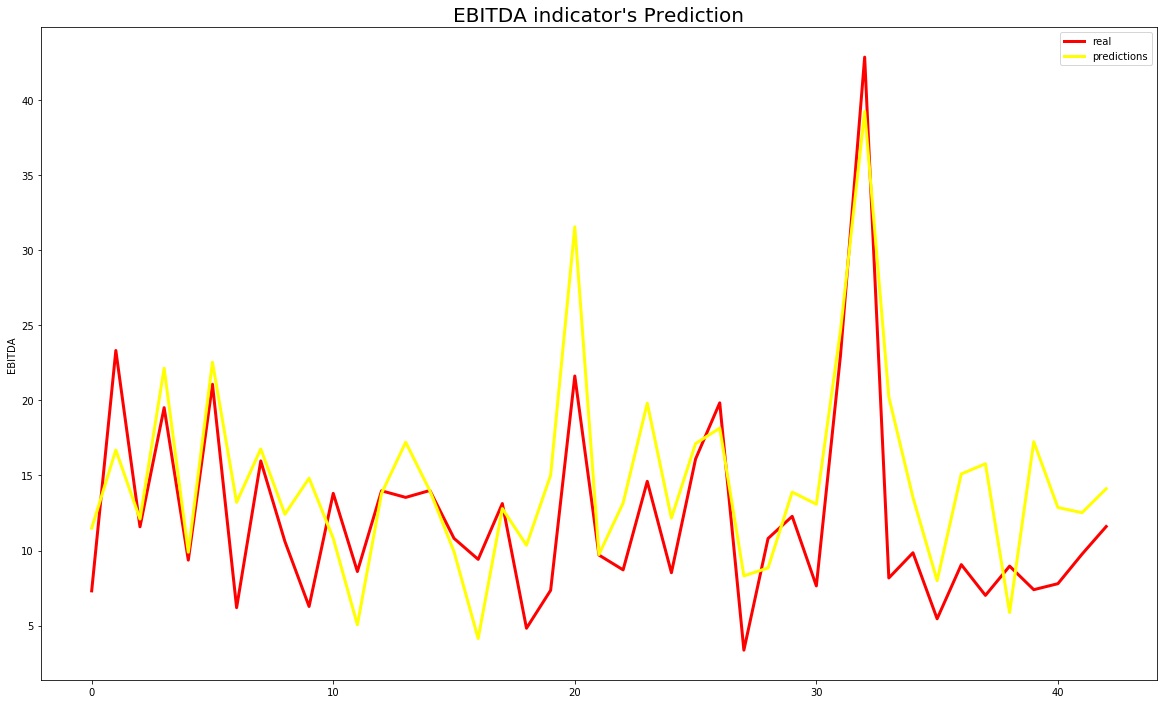

In [68]:
# Plot real values against prediction values 
plot_test_result(de_pred, de_y_test, fra=0, color='yellow', label='predictions')

Confusion Matrix
Apart from the accuracy, the following performance measures for the models are also very helpful to measure it's performance on test dataset.

The number of samples correctly predicted as negative i.e True Negative (TN).

The number of samples correctly predicted as positive i.e True Positive (TP). These are also used in accuracy calculation.

The number of samples which were positive but were predicted as negative i.e False Negative (FN).

The number of samples which were negative but were predicted as positive i.e False Positive (FP).

Confusion matrix gives above mentioned metrics of performance and is widely used for classification task.

We have created a utility to visualize confusion matrix based on the dataset.

In [69]:

#plot the confusion matrix，
from sklearn.metrics import confusion_matrix
#function
def plot_cm(y_test_act, y_test_pred, title="Confusion Matrix", cmap="Blues"):
    """
    plot the confusion matrix given the test label and predicted label.
    
    @arguements:
    y_test_act -- actual label (0 or 1) of the data set.
    y_test_pred -- model's predicted label (o or 1) of the data set.
    title -- title string to be put on plot. default -- Confusion Matrix
    cmap -- matplotlib color palette to be used. default -- Blues
    """
    
#     fig, ax = plt.subplots()
#     cm = confusion_matrix(y_test_act, y_test_pred)
#     tp = cm[1,1]
#     tn = cm[0,0]
#     fp = cm[0,1]
#     fn = cm[1,0]
#     sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap = cmap, ax = ax)
#     ax.set_title(title)
#     ax.set_xlabel("Predicted class")
#     ax.set_ylabel("Actual class")
#     plt.show()

In [70]:
#de_y_test is test target,act
#de_pred is predictions
# print(str( de_pred ))
plot_cm(de_y_test, de_pred, title="Confusion Matrix", cmap="Blues")

What is the mean number of GAs EBITDA ?

In [71]:
#what is the mean of GAs EBITDA means?
de_pred.mean()
pre_ebitda = de_pred.mean()

Means method

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001643F847A90>],
      dtype=object)

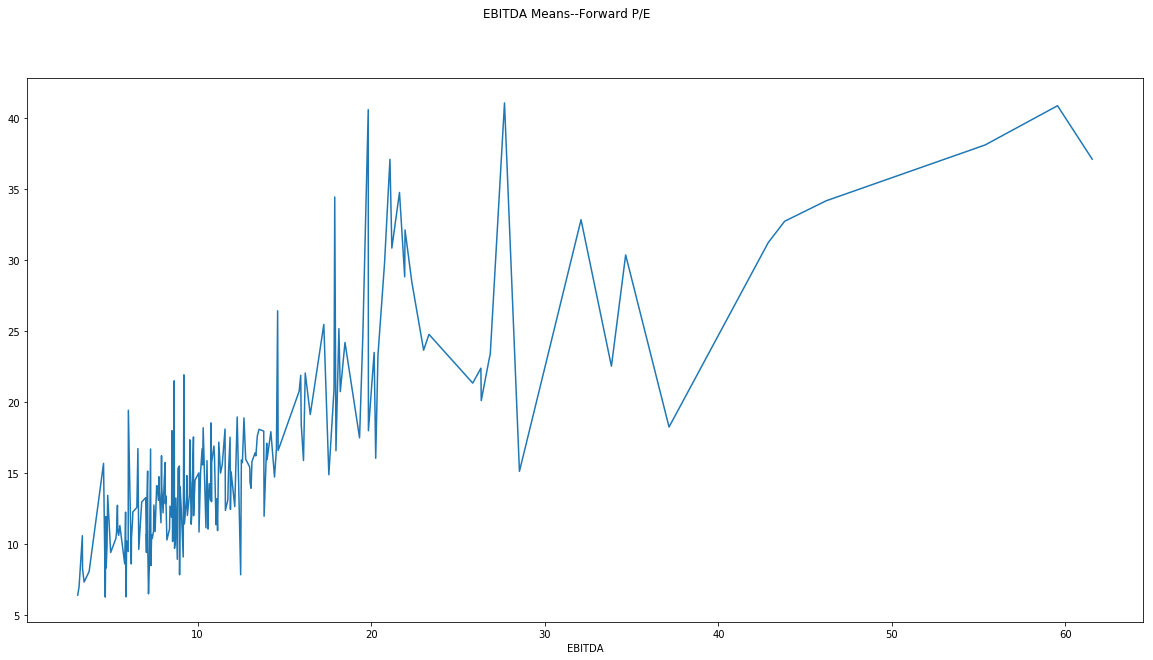

In [72]:
# means assess again.
ebmean1= financeData.groupby('EBITDA').mean() 

fig = plt.figure(figsize=(20,10))
# # visualize the stock_data
ebmean1.ForwardP_E.plot(subplots=True, title='EBITDA Means--Forward P/E')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001643F632F28>],
      dtype=object)

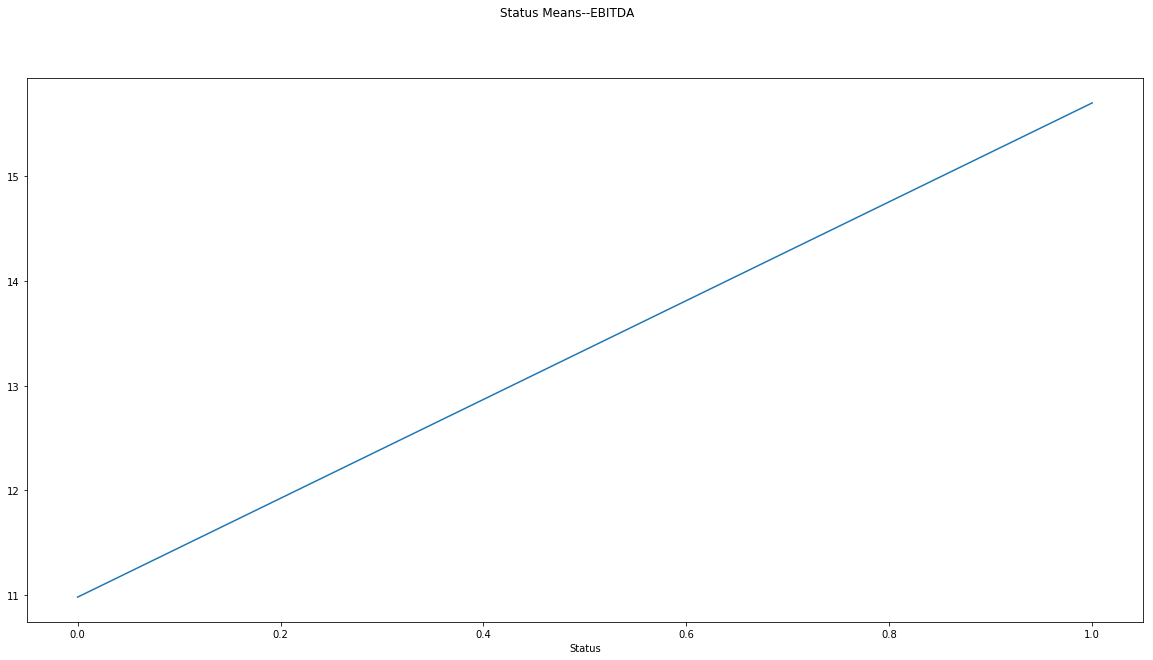

In [73]:
# means assess again.
ebmean= financeData.groupby('Status').mean() 

fig = plt.figure(figsize=(20,10))
# # visualize the stock_data
ebmean.EBITDA.plot(subplots=True, title='Status Means--EBITDA')

In [74]:
# means
eb_groups = pd.cut(financeData['EBITDA'], bins=[18,25,31,np.inf])
#eb_groups = pd.cut(np.array(ebmean1), bins=[15,25,30,np.inf])
financeData.groupby(eb_groups).mean()


,Beta,BookValuePerShare,CurrentRatio,EBITDA,EarningsGrowth,EnterpriseValue_Revenue,ForwardP_E,HeldbyInstitutions,OperatingMargin,PEGRatio,Price,Price_Book,Price_Sales,ProfitMargin,ReturnonAssets,Revenue,RevenueGrowth,Status,TotalCashPerShare,TrailingP_E
EBITDA,,,,,,,,,,,,,,,,,,,,
"(18.0, 25.0]",1.548000,7.271158,2.960105,20.601579,73.147368,7.317368,26.521579,83.373158,29.639474,1.704737,44.440526,6.911053,7.584737,21.593158,14.097895,7.317368,19.763158,0.578947,4.312105,37.973158
"(25.0, 31.0]",1.323571,7.537857,3.248571,26.912857,176.957143,4.225714,23.770000,82.112857,13.774286,1.604286,46.134286,6.501429,4.752857,10.811429,9.504286,4.225714,17.000000,0.428571,5.570000,51.521429
"(31.0, inf]",1.267200,10.517200,3.627800,44.711000,133.950000,10.221000,31.808000,86.071000,20.821000,1.587000,71.133000,7.745000,10.734000,13.689000,8.887000,10.221000,34.400000,0.900000,7.819000,77.736000


Cross table making,just check,look for some idea.

In [75]:
pd.crosstab( eb_groups, financeData['ForwardP_E'] )

ForwardP_E,15.12,16.04,17.48,17.98,18.24,20.1,20.73,21.33,22.38,22.52,...,32.72,32.83,34.16,34.75,37.08,37.09,38.09,40.58,40.85,41.05
EBITDA,,,,,,,,,,,,,,,,,,,,,
"(18.0, 25.0]",0,1,1,1,0,0,1,0,0,0,...,0,0,0,1,1,0,0,1,0,0
"(25.0, 31.0]",1,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
"(31.0, inf]",0,0,0,0,1,0,0,0,0,1,...,1,1,1,0,0,1,1,0,1,0


NEED some idea here....skip
Next

Will with sharp ratio to assess 

In [76]:
#total desc of EBITDA
financeData.EBITDA.describe()

count    212.000000
mean      12.849241
std        9.126926
min        3.090000
25%        7.670000
50%       10.215000
75%       14.272500
max       61.540000
Name: EBITDA, dtype: float64

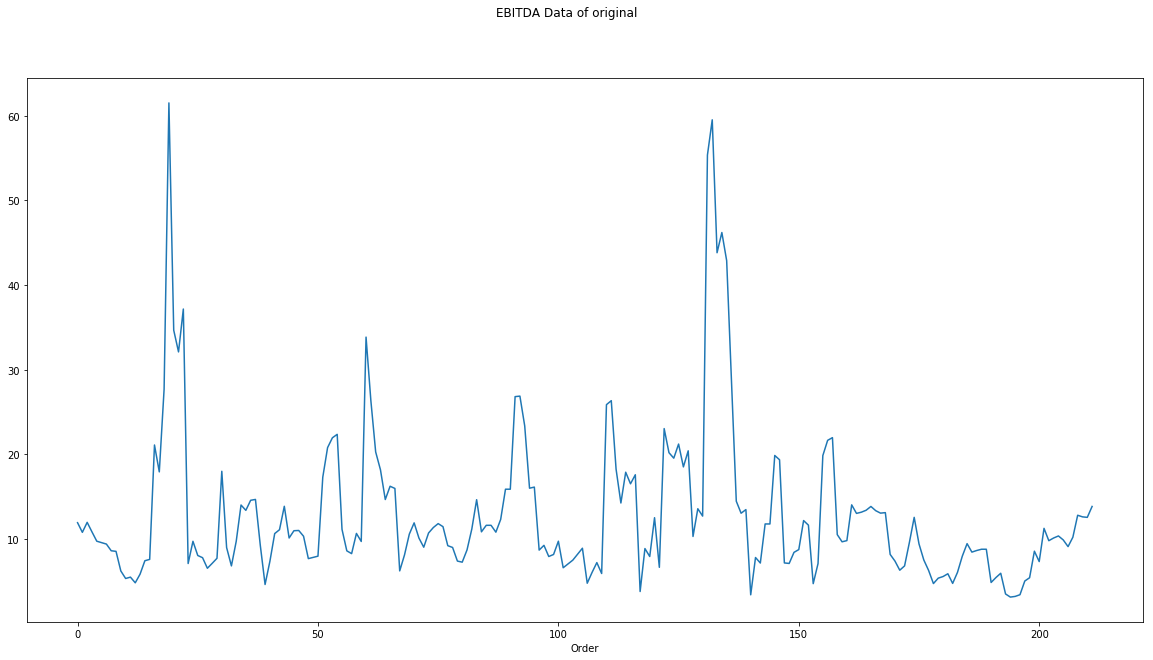

In [77]:
#copy, keep the original data status
fig = plt.figure(figsize=(20,10))
financeData.EBITDA.plot(subplots=True, title='EBITDA Data of original')
financeData_win = financeData.copy()
financeData_win= financeData_win.drop(financeData_win[(financeData_win['Status']==0) ].index)

In [78]:
#outplatform desc
financeData_win.describe()

,Beta,BookValuePerShare,CurrentRatio,EBITDA,EarningsGrowth,EnterpriseValue_Revenue,ForwardP_E,HeldbyInstitutions,OperatingMargin,PEGRatio,Price,Price_Book,Price_Sales,ProfitMargin,ReturnonAssets,Revenue,RevenueGrowth,Status,TotalCashPerShare,TrailingP_E
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.0,84.000000,84.00000
mean,1.084179,20.987821,1.986310,15.701548,55.363095,3.648452,18.548571,77.727619,18.406786,1.576071,55.335714,4.243452,3.623690,12.014048,9.112857,3.648452,19.491667,1.0,5.057857,30.78869
std,0.628415,22.186599,1.088971,12.394586,88.588258,4.393702,9.301074,18.947647,14.293683,0.888658,48.990653,3.211960,4.458844,9.373403,6.369210,4.393702,13.771659,0.0,6.418547,25.57244
min,0.035000,2.847000,0.410000,3.090000,1.400000,0.310000,6.410000,2.600000,1.840000,0.620000,16.280000,0.830000,0.200000,1.370000,1.150000,0.310000,0.100000,1.0,0.300000,7.88000
25%,0.547500,9.040250,1.201250,8.080000,11.350000,0.857500,12.185000,70.735000,4.030000,0.967500,33.300000,1.860000,1.037500,2.760000,4.205000,0.857500,8.100000,1.0,1.290000,15.88250
50%,1.046000,13.489000,1.625500,11.105000,29.250000,2.160000,15.675000,82.175000,15.590000,1.420000,47.990000,3.070000,1.895000,10.710000,6.625000,2.160000,16.700000,1.0,3.105000,21.91000
75%,1.590750,26.100000,2.620750,19.970000,57.875000,3.985000,23.712500,89.745000,30.022500,1.805000,64.665000,5.962500,3.805000,18.387500,12.315000,3.985000,28.925000,1.0,6.062500,34.12000
max,2.659000,135.790000,6.780000,61.540000,581.400000,18.470000,41.050000,100.800000,49.360000,5.770000,454.000000,12.960000,19.040000,37.330000,26.310000,18.470000,63.700000,1.0,46.970000,141.34000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001643F5F3F60>],
      dtype=object)

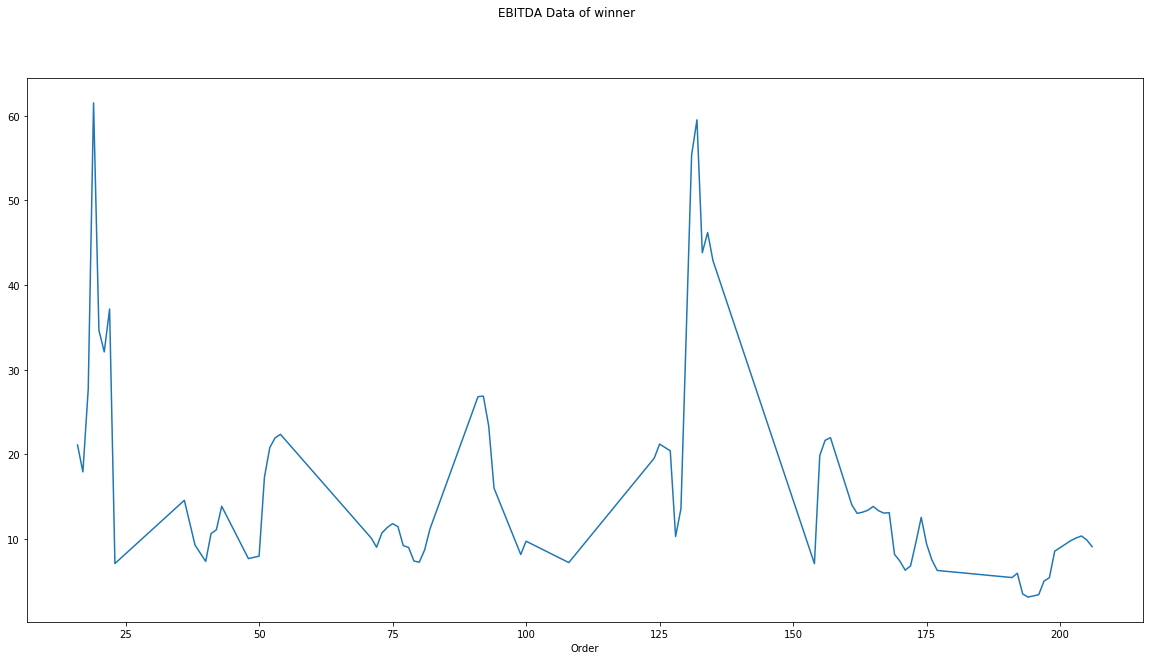

In [79]:
#
fig = plt.figure(figsize=(20,10))
financeData_win.EBITDA.plot(subplots=True, title='EBITDA Data of winner')

,Beta,BookValuePerShare,CurrentRatio,EBITDA,EarningsGrowth,EnterpriseValue_Revenue,ForwardP_E,HeldbyInstitutions,OperatingMargin,PEGRatio,Price,Price_Book,Price_Sales,ProfitMargin,ReturnonAssets,Revenue,RevenueGrowth,Status,TotalCashPerShare,TrailingP_E
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.0,128.000000,128.000000
mean,1.285398,17.732094,2.473586,10.977414,67.462500,2.539922,14.565547,78.681250,17.430469,1.587891,41.210625,3.415156,2.537031,11.752969,6.966719,2.539922,12.945312,0.0,5.285383,31.685625
std,0.744204,12.457236,1.916557,5.392948,99.115414,1.856641,4.373840,15.505486,10.130621,0.977403,21.294005,3.169444,2.029763,8.068997,4.074512,1.856641,11.893728,0.0,5.622992,80.429073
min,0.024000,1.570000,0.430000,3.170000,0.900000,0.120000,5.240000,1.500000,1.320000,0.280000,8.000000,0.620000,0.110000,0.320000,0.680000,0.120000,0.200000,0.0,0.109000,7.300000
25%,0.640000,10.016500,1.140000,7.442500,12.450000,0.887500,11.767500,74.700000,9.390000,1.057500,28.300000,1.610000,0.910000,5.572500,3.860000,0.887500,4.100000,0.0,1.625000,14.092500
50%,1.385000,14.009500,1.544500,9.690000,37.500000,2.410000,13.780000,81.310000,16.090000,1.430000,39.000000,2.425000,2.005000,10.685000,5.445000,2.410000,10.050000,0.0,3.710000,19.875000
75%,1.810000,25.267500,3.209750,12.830000,84.350000,3.630000,17.117500,87.425000,25.577500,1.712500,51.530000,4.222500,3.737500,17.445000,9.287500,3.630000,16.700000,0.0,6.980000,25.182500
max,2.770000,76.870000,9.470000,33.840000,890.000000,9.990000,26.420000,102.700000,44.710000,6.510000,113.000000,23.320000,8.600000,31.010000,18.900000,9.990000,63.700000,0.0,32.150000,673.810000


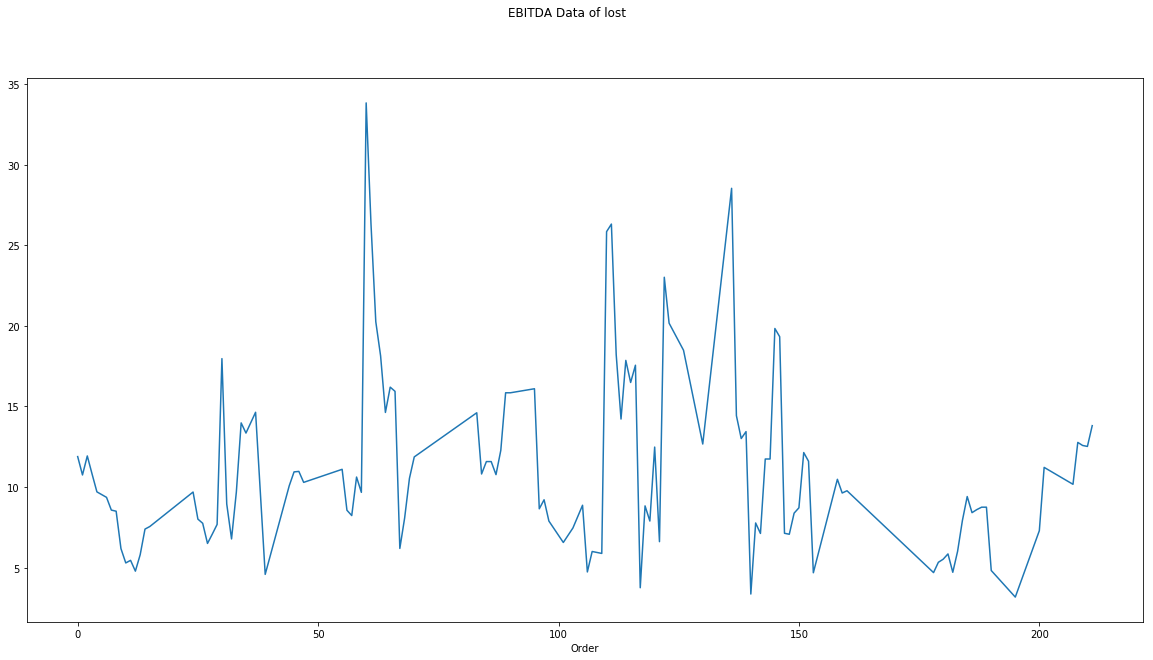

In [80]:
#copy
fig = plt.figure(figsize=(20,10))
financeData_los = financeData.copy()
financeData_los= financeData_los.drop(financeData_los[(financeData_los['Status']==1) ].index)
financeData_los.EBITDA.plot(subplots=True, title='EBITDA Data of lost')
financeData_los.describe()

Loss,EBITDA 75% 	under 12.830000 	
And the GAs predict EBITDA means :7.6905510
If one new data set is input, we must know the location of the EBITDA of it.

,Beta,BookValuePerShare,CurrentRatio,EBITDA,EarningsGrowth,EnterpriseValue_Revenue,ForwardP_E,HeldbyInstitutions,OperatingMargin,PEGRatio,Price,Price_Book,Price_Sales,ProfitMargin,ReturnonAssets,Revenue,RevenueGrowth,Status,TotalCashPerShare,TrailingP_E
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,0.0,127.000000,127.000000
mean,0.315114,0.333287,0.121951,0.108701,2.350697,0.348314,0.059340,0.427677,0.229626,0.119542,0.085906,0.455086,0.384818,0.934852,0.249384,0.348314,0.763546,NaN,1.203975,0.503919
std,2.201015,2.006339,0.768354,0.582952,9.481589,2.078170,0.412028,3.940910,1.446818,0.539250,0.559413,3.285200,2.259647,6.704104,1.578877,2.078170,3.493452,NaN,5.749978,4.257956
min,-0.932044,-0.931775,-0.836008,-0.786446,-0.980687,-0.963504,-0.665816,-0.972437,-0.951432,-0.799534,-0.692308,-0.934820,-0.967742,-0.972556,-0.814249,-0.963504,-0.974882,NaN,-0.987952,-0.951233
25%,-0.090280,-0.023692,-0.084656,-0.114696,-0.459805,-0.103869,-0.111401,-0.013082,-0.075552,-0.096485,-0.079823,-0.125996,-0.104032,-0.127723,-0.132382,-0.103869,-0.255435,NaN,-0.169992,-0.184802
50%,0.000000,0.003843,0.000000,0.000000,0.000000,0.000000,0.015534,0.000000,0.000000,0.027972,0.015385,-0.003478,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
75%,0.090635,0.076056,0.045106,0.162747,0.417658,0.153224,0.117255,0.024867,0.061102,0.185999,0.113787,0.114282,0.157716,0.096053,0.113751,0.153224,0.395064,NaN,0.296350,0.186220
max,23.838710,18.727273,6.032558,3.396259,75.375000,20.352941,2.391097,42.680000,11.075949,2.289474,4.375000,33.805970,20.250000,69.000000,15.585586,20.352941,32.666667,NaN,44.176471,47.256506


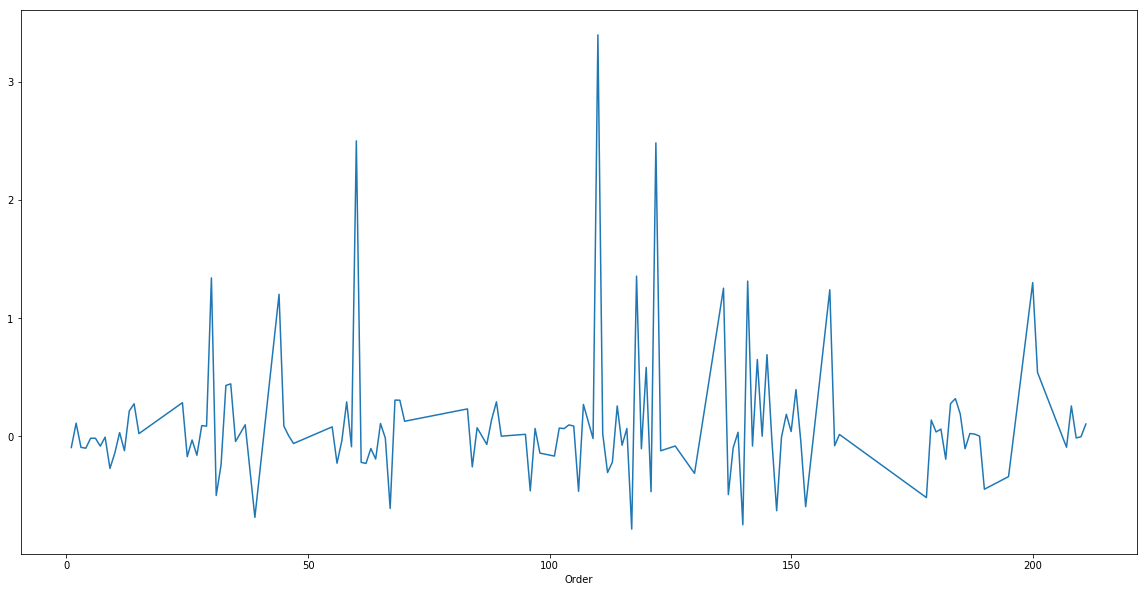

In [81]:

# calculate financial report period EBITDA returns
fin_los_rt = financeData_los.pct_change()
fig = plt.figure(figsize=(20,10))
# plot the los returns
fin_los_rt.EBITDA.plot()

# summarize the los returns
fin_los_rt.describe()

,Beta,BookValuePerShare,CurrentRatio,EBITDA,EarningsGrowth,EnterpriseValue_Revenue,ForwardP_E,HeldbyInstitutions,OperatingMargin,PEGRatio,Price,Price_Book,Price_Sales,ProfitMargin,ReturnonAssets,Revenue,RevenueGrowth,Status,TotalCashPerShare,TrailingP_E
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.0,83.000000,83.000000
mean,0.588297,0.287564,0.123363,0.099318,5.120975,0.381070,0.068043,0.791697,0.250599,0.110149,0.150795,0.193951,0.475367,0.328514,0.263170,0.381070,3.182069,0.0,0.568294,0.217076
std,2.995154,1.199432,0.870194,0.568962,31.251244,1.690707,0.555764,4.711443,1.094622,0.643104,1.036316,0.886761,2.237954,1.420131,1.191551,1.690707,21.541394,0.0,2.138656,1.294224
min,-0.955696,-0.938736,-0.686099,-0.835588,-0.973602,-0.953035,-0.698687,-0.962697,-0.922967,-0.888689,-0.898833,-0.854855,-0.965153,-0.936985,-0.900862,-0.953035,-0.996622,0.0,-0.973813,-0.846045
25%,-0.079360,-0.008731,-0.093531,-0.148896,-0.419203,-0.125824,-0.132399,-0.016476,-0.053121,-0.156085,-0.079429,-0.139812,-0.133345,-0.044531,-0.067105,-0.125824,-0.326007,0.0,-0.167932,-0.166381
50%,0.000000,0.019259,0.000000,0.014794,0.000000,0.017241,-0.026223,0.000000,0.000000,-0.013699,0.055556,0.016878,0.022556,0.000000,0.000000,0.017241,0.000000,0.0,0.000000,0.014231
75%,0.126962,0.114291,0.059663,0.151767,0.404416,0.099473,0.093545,0.042689,0.054628,0.134788,0.208081,0.189820,0.113500,0.150291,0.097430,0.099473,0.134524,0.0,0.324506,0.148634
max,21.571429,8.487842,6.247619,3.089365,275.857143,11.774194,3.312434,32.557692,7.010870,3.889831,9.120374,5.114035,16.791667,9.912409,7.139665,11.774194,195.000000,0.0,13.210526,10.059468


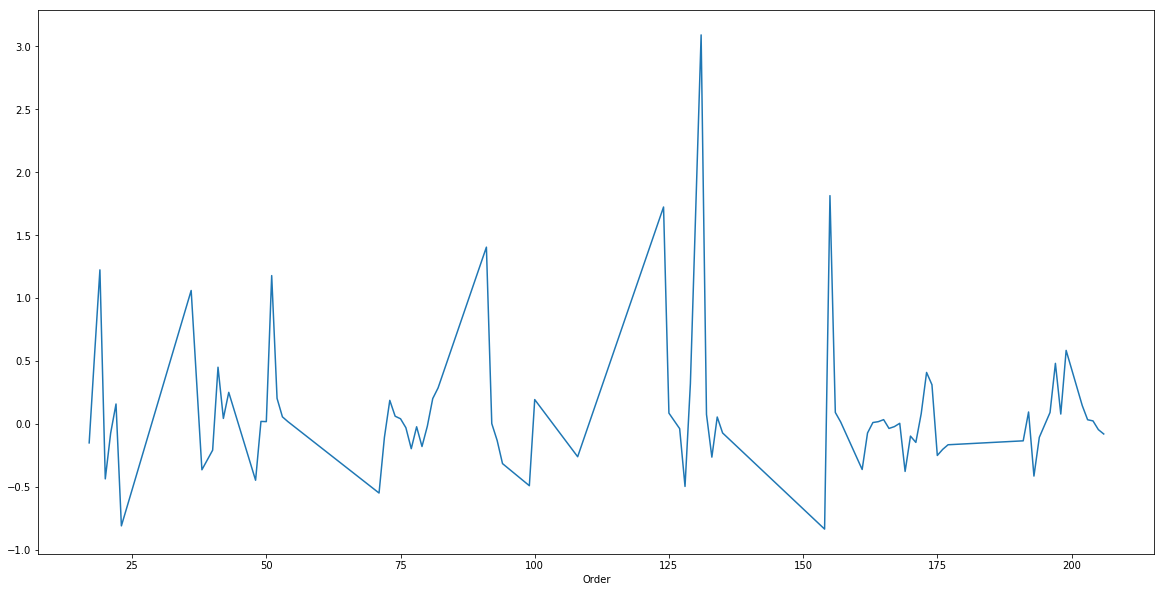

In [82]:

# calculate financial report period EBITDA returns
fin_win_rt = financeData_win.pct_change()
fig = plt.figure(figsize=(20,10))
# plot the los returns
fin_win_rt.EBITDA.plot()

# summarize the los returns
fin_win_rt.describe()

To check the sample data. 


,Beta,BookValuePerShare,CurrentRatio,EBITDA,EarningsGrowth,EnterpriseValue_Revenue,ForwardP_E,HeldbyInstitutions,OperatingMargin,PEGRatio,Price,Price_Book,Price_Sales,ProfitMargin,ReturnonAssets,Revenue,RevenueGrowth,Status,TotalCashPerShare,TrailingP_E
count,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.0,211.000000,211.000000
mean,-0.002175,0.041076,-0.001849,0.002160,0.220188,0.006625,-0.004416,-0.000187,0.022301,-0.004140,0.046786,0.003325,0.004011,0.020010,0.013159,0.006625,0.010191,0.0,0.022437,-0.002616
std,0.035746,0.584323,0.019877,0.113264,3.263191,0.071352,0.046496,0.014885,0.239761,0.059591,0.630170,0.056899,0.058223,0.229813,0.121995,0.071352,0.225525,0.0,0.343018,0.070040
min,-0.516667,0.000000,-0.271600,-0.810011,-0.927333,-0.245955,-0.444411,-0.172009,0.000000,-0.689320,-0.423467,-0.440647,-0.436364,0.000000,0.000000,-0.245955,-0.973054,0.0,-0.500000,-0.842661
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
max,0.033257,8.487842,0.000000,1.223266,47.387097,0.819549,0.192274,0.089164,3.390462,0.275472,9.120374,0.607029,0.555556,3.284615,1.594268,0.819549,3.123457,0.0,4.953105,0.276126


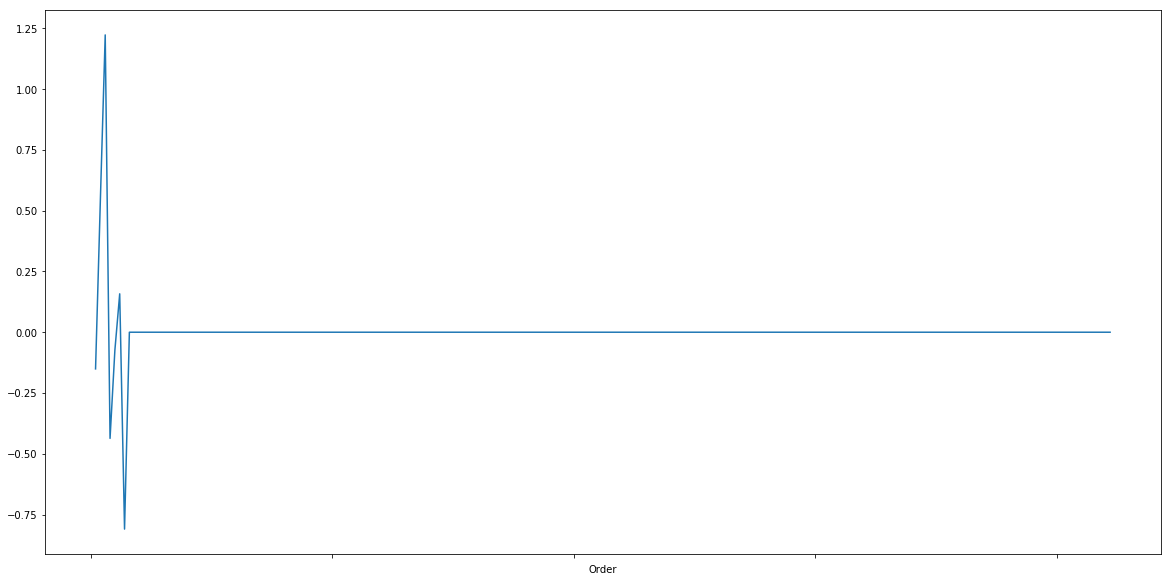

In [83]:
# calculate financial report period EBITDA returns
spl_rt = winData.pct_change()
fig = plt.figure(figsize=(20,10))
# plot the los returns
spl_rt.EBITDA.plot()

# summarize the los returns
spl_rt.describe()